# Emissions de polluants dans l'air 

In [1]:
import sys
sys.path.append('../../')
import re
from config.settings import settings
from slugify import slugify

import dtale as dt
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
DATASETS_BASE = settings.MODULES_TO_DATASETS_PATH

## Récupération des datasets

### F5-1 ENERGY

In [3]:
df_f5_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_ENERGY_F5_1, low_memory=False)
df_f5_1.head()

countryName  reportingYear typefeature      feature unit  featureValue
0     Austria           2016        fuel      Biomass   TJ       8903.96
1     Austria           2016        fuel         Coal   TJ          0.00
2     Austria           2016        fuel      Lignite   TJ          0.00
3     Austria           2016        fuel  LiquidFuels   TJ      14558.74
4     Austria           2016        fuel   NaturalGas   TJ      83034.06

### F5-2 ENERGY

In [4]:
df_f5_2 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_ENERGY_F5_2, low_memory=False)
df_f5_2.head()

countryName  reportingYear                LCPInspireID installationPartName   
0     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3  \
1     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   
2     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   
3     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   
4     Austria           2016  AT.CAED/9008390225387.PART         Sodakessel 3   

  installationPartNameConfidentialityReason  Longitude   Latitude   
0                                       NaN  14.256111  48.183056  \
1                                       NaN  14.256111  48.183056   
2                                       NaN  14.256111  48.183056   
3                                       NaN  14.256111  48.183056   
4                                       NaN  14.256111  48.183056   

  addressConfidentialityReason featureType      feature unit  featureValue   
0                          NaN        fuel      Biomass   TJ          0.00  \
1                          NaN        fuel         Coal   TJ          0.00   
2                          NaN        fuel      Lignite   TJ          0.00   
3                          NaN        fuel  LiquidFuels   TJ         15.63   
4                          NaN        fuel   NaturalGas   TJ          0.00   

   ConfidentialityReason  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

### F6-1 INFORMATION

In [5]:
df_f6_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_INFORMATION_F6_1, low_memory=False)
df_f6_1.head()

countryName  reportingYear               InstallationInspireID   
0     Austria           2017  AT.CAED/9008390374726.INSTALLATION  \
1     Austria           2017  AT.CAED/9008390374726.INSTALLATION   
2     Austria           2017  AT.CAED/9008390374726.INSTALLATION   
3     Austria           2018  AT.CAED/9008390374726.INSTALLATION   
4     Austria           2018  AT.CAED/9008390374726.INSTALLATION   

   installationName installationNameConfidentialityReason  Longitude   
0               NaN                                   NaN  13.691667  \
1               NaN                                   NaN  13.691667   
2               NaN                                   NaN  13.691667   
3               NaN                                   NaN  13.691667   
4               NaN                                   NaN  13.691667   

    Latitude addressConfidentialityReason CityofFacility IEDActivityCode  ...   
0  46.556667                          NaN    Arnoldstein          5.2(a)  ...  \
1  46.556667                          NaN    Arnoldstein          5.2(a)  ...   
2  46.556667                          NaN    Arnoldstein          5.2(a)  ...   
3  46.556667                          NaN    Arnoldstein          5.2(a)  ...   
4  46.556667                          NaN    Arnoldstein          5.2(a)  ...   

  siteVisitNumber  relevantChapter dateOfGranting  permitGranted   
0             0.0              NaN     20111013.0            Yes  \
1             0.0              NaN     20111013.0            Yes   
2             0.0              NaN     20111013.0            Yes   
3             0.0              NaN     20111013.0            Yes   
4             0.0              NaN     20111013.0            Yes   

  permitReconsidered permitUpdated dateOfLastUpdate  permitURL    featureType   
0                Yes            No              NaN        NaN         BATAEL  \
1                Yes            No              NaN        NaN  BATConclusion   
2                Yes            No              NaN        NaN  BATDerogation   
3                Yes            No              NaN        NaN         BATAEL   
4                Yes            No              NaN        NaN  BATConclusion   

  featureValue  
0          NaN  
1           WI  
2          NaN  
3          NaN  
4           WI  

[5 rows x 21 columns]

### F7-1 INFORMATION

In [6]:
df_f7_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_INFORMATION_F7_1, low_memory=False)
df_f7_1.head()

countryName              PlantInspireID            installationPartName   
0     Austria  AT.CAED/9008390374726.PART                             TBA  \
1     Austria  AT.CAED/9008390429518.PART  RIK - Rindenverbrennungskessel   
2     Austria  AT.CAED/9008390446867.PART                    Drehrohrofen   
3     Austria  AT.CAED/9008390463598.PART     Abfallmitverbrennungsanlage   
4     Austria  AT.CAED/9008390480021.PART           Wirbelschichtkessel 4   

  installationPartNameConfidentialityReason  Longitude   Latitude   
0                                       NaN  13.691667  46.556667  \
1                                       NaN  14.860556  46.861000   
2                                       NaN  13.692917  46.553139   
3                                       NaN  16.084944  47.873444   
4                                       NaN  16.175639  47.707278   

  addressConfidentialityReason CityofFacility  reportingYear plantType   
0                          NaN    Arnoldstein           2017        WI  \
1                          NaN    Frantschach           2017     co-WI   
2                          NaN        Gailitz           2017        WI   
3                          NaN        Wopfing           2017     co-WI   
4                          NaN         Pitten           2017     co-WI   

   totalNominalCapacityAnyWaste  permittedCapacityNonHazardous   
0                         12.15                          12.15  \
1                          2.00                           2.00   
2                          2.70                           2.70   
3                         30.00                          22.00   
4                          6.25                           6.25   

  untreatedMunicipalWaste   
0                      No  \
1                      No   
2                      No   
3                      No   
4                      No   

                                                                                  publicDisclosure   
0  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.  \
1  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   
2  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   
3  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   
4  Dieser Bericht wird jährlich erstellt und auf der Homepage des BMK (siehe Link) veröffentlicht.   

                                                                                      publicDisclosureURL   
0  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html  \
1  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   
2  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   
3  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   
4  https://www.bmk.gv.at/themen/klima_umwelt/abfall/Kreislaufwirtschaft/verwertung/thermisch/bericht.html   

  specificConditionsPermitURL         ParentInstallationInspireID  
0                         NaN  AT.CAED/9008390374726.INSTALLATION  
1                         NaN  AT.CAED/9008390429518.INSTALLATION  
2                         NaN  AT.CAED/9008390446867.INSTALLATION  
3                         NaN  AT.CAED/9008391276616.INSTALLATION  
4                         NaN  AT.CAED/9008390682555.INSTALLATION

### F1 AIR

In [7]:
df1_1 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_1)
df1_1.head()

countryName                       pollutant  reportingYear    emissions
0     Austria            Carbon monoxide (CO)           2007  163261000.0
1     Austria    Copper and compounds (as Cu)           2007        380.0
2     Austria      Zinc and compounds (as Zn)           2007      18820.0
3     Austria  Chromium and compounds (as Cr)           2008        389.0
4     Austria           Nitrogen oxides (NOX)           2009   19103000.0

In [8]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryName    11541 non-null  object 
 1   pollutant      11541 non-null  object 
 2   reportingYear  11541 non-null  int64  
 3   emissions      11541 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 360.8+ KB


### F2 AIR

In [9]:
df1_2 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_2)
df1_2.head()

countryName  reportingYear targetRelease  EPRTRSectorCode eprtrSectorName   
0     Austria           2007           AIR              1.0   Energy sector  \
1     Austria           2007           AIR              1.0   Energy sector   
2     Austria           2007           AIR              1.0   Energy sector   
3     Austria           2007           AIR              1.0   Energy sector   
4     Austria           2007           AIR              1.0   Energy sector   

                   pollutant     emissions  
0       Carbon dioxide (CO2)  2.870000e+09  
1      Nitrogen oxides (NOX)  3.050000e+06  
2  Particulate matter (PM10)  9.250000e+04  
3       Sulphur oxides (SOX)  3.230000e+06  
4       Carbon dioxide (CO2)  8.454000e+09

In [10]:
df1_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62104 entries, 0 to 62103
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   countryName      62104 non-null  object 
 1   reportingYear    62104 non-null  int64  
 2   targetRelease    62104 non-null  object 
 3   EPRTRSectorCode  61957 non-null  float64
 4   eprtrSectorName  61957 non-null  object 
 5   pollutant        62104 non-null  object 
 6   emissions        62104 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.3+ MB


In [11]:
print("targetRelease :", df1_2.targetRelease.unique())
print("EPRTRSectorCode :", df1_2.EPRTRSectorCode.unique())
print("eprtrSectorName :", df1_2.eprtrSectorName.unique())

targetRelease : ['AIR']
EPRTRSectorCode : [ 1.  2.  3.  4.  5.  6.  8.  9.  7. nan]
eprtrSectorName : ['Energy sector' 'Production and processing of metals' 'Mineral industry'
 'Chemical industry' 'Waste and wastewater management'
 'Paper and wood production and processing'
 'Animal and vegetable products from the food and beverage sector'
 'Other activities' 'Intensive livestock production and aquaculture' nan]


### F3 AIR

In [12]:
df1_3 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_3)
df1_3.head()

countryName  EPRTRSectorCode eprtrSectorName EPRTRAnnexIMainActivityCode   
0     Austria              1.0   Energy sector                        1(a)  \
1     Austria              1.0   Energy sector                        1(a)   
2     Austria              1.0   Energy sector                        1(a)   
3     Austria              1.0   Energy sector                        1(a)   
4     Austria              1.0   Energy sector                        1(c)   

                                EPRTRAnnexIMainActivityLabel targetRelease   
0                             Mineral oil and gas refineries           AIR  \
1                             Mineral oil and gas refineries           AIR   
2                             Mineral oil and gas refineries           AIR   
3                             Mineral oil and gas refineries           AIR   
4  Thermal power stations and other combustion installations           AIR   

   reportingYear                  pollutant     emissions  
0           2007       Carbon dioxide (CO2)  2.870000e+09  
1           2007      Nitrogen oxides (NOX)  3.050000e+06  
2           2007  Particulate matter (PM10)  9.250000e+04  
3           2007       Sulphur oxides (SOX)  3.230000e+06  
4           2007       Carbon dioxide (CO2)  8.454000e+09

In [13]:
df1_3.EPRTRAnnexIMainActivityLabel.unique()

array(['Mineral oil and gas refineries',
       'Thermal power stations and other combustion installations',
       'Installations for the production of pig iron or steel (primary or secondary melting) including continuous casting',
       'Ferrous metal foundries with a production capacity of 20 tonnes per day',
       'Installations for the production and/or smelting of non-ferrous metals. Note to reporters, use Level 3 activity e.g. 2(e)(i), in preference to 2(e). Level 2 activity class (i.e. 2(e)) only to be used where Level 3 is not available.',
       'Installations for surface treatment of metals and plastic materials using an electrolytic or chemical process',
       'Installations for the production of cement clinker in rotary kilns, lime in rotary kilns, cement or lime in other furnaces. Note to reporters, use Level 3 activity e.g. 3(c)(i), in preference to 3(c). Level 2 activity class (i.e. 3(c)) only to be used where Level 3 is not available.',
       'Installations for the

In [14]:
df1_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62104 entries, 0 to 62103
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   countryName                   62104 non-null  object 
 1   EPRTRSectorCode               61957 non-null  float64
 2   eprtrSectorName               61957 non-null  object 
 3   EPRTRAnnexIMainActivityCode   61957 non-null  object 
 4   EPRTRAnnexIMainActivityLabel  61957 non-null  object 
 5   targetRelease                 62104 non-null  object 
 6   reportingYear                 62104 non-null  int64  
 7   pollutant                     62104 non-null  object 
 8   emissions                     62104 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 4.3+ MB


### F4 AIR

In [15]:
df1_4 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_4, low_memory=False)
df1_4.head()

countryName  EPRTRSectorCode                           eprtrSectorName   
0     Austria              4.0                         Chemical industry  \
1     Austria              9.0                          Other activities   
2     Austria              6.0  Paper and wood production and processing   
3     Austria              6.0  Paper and wood production and processing   
4     Austria              3.0                          Mineral industry   

  EPRTRAnnexIMainActivityCode   
0                        4(d)  \
1                        9(c)   
2                        6(b)   
3                        6(b)   
4                        3(c)   

                                                                                                                                                                                                                                                                  EPRTRAnnexIMainActivityLabel   
0                                                                                                                                                                              Chemical installations for the production on an industrial scale of basic plant health products and of biocides  \
1                                                                      Installations for the surface treatment of substances, objects or products using organic solvents, in particular for dressing, printing, coating, degreasing, waterproofing, sizing, painting, cleaning or impregnating   
2                                                                                                                                                          Industrial plants for the production of paper and board and other primary wood products (such as chipboard, fibreboard and plywood)   
3                                                                                                                                                          Industrial plants for the production of paper and board and other primary wood products (such as chipboard, fibreboard and plywood)   
4  Installations for the production of cement clinker in rotary kilns, lime in rotary kilns, cement or lime in other furnaces. Note to reporters, use Level 3 activity e.g. 3(c)(i), in preference to 3(c). Level 2 activity class (i.e. 3(c)) only to be used where Level 3 is not available.   

                FacilityInspireID                          facilityName   
0  AT.CAED/9008390392737.FACILITY                   Nufarm GmbH & CO KG  \
1  AT.CAED/9008390396414.FACILITY  MAGNA STEYR Fahrzeugtechnik AG&Co KG   
2  AT.CAED/9008390397176.FACILITY             Fritz EGGER GmbH & Co. OG   
3  AT.CAED/9008390397176.FACILITY             Fritz EGGER GmbH & Co. OG   
4  AT.CAED/9008390397220.FACILITY                voestalpine Stahl GmbH   

  facilityNameConfidentialityReason  Longitude   Latitude   
0                               NaN  14.336056  48.290943  \
1                               NaN  15.477778  47.019170   
2                               NaN  15.691833  48.259556   
3                               NaN  15.691833  48.259556   
4                               NaN  14.159778  47.807083   

  addressConfidentialityReason                    City targetRelease   
0                          NaN                    Linz           AIR  \
1                          NaN   Graz,07.Bez.:Liebenau           AIR   
2                          NaN           Unterradlberg           AIR   
3                          NaN           Unterradlberg           AIR   
4                          NaN  Klaus an der Pyhrnbahn           AIR   

                                        pollutant    emissions  reportingYear   
0                    1,2-dichloroethane (DCE-1,2)       3300.0           2007  \
1  Non-methane volatile organic compounds (NMVOC)     170000.0           2007   
2                            Carbon dioxide (CO2)  228000000.0           2007   
3                           Ni

In [16]:
df1_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324555 entries, 0 to 324554
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   countryName                        324555 non-null  object 
 1   EPRTRSectorCode                    323540 non-null  float64
 2   eprtrSectorName                    323540 non-null  object 
 3   EPRTRAnnexIMainActivityCode        323540 non-null  object 
 4   EPRTRAnnexIMainActivityLabel       323540 non-null  object 
 5   FacilityInspireID                  324555 non-null  object 
 6   facilityName                       324159 non-null  object 
 7   facilityNameConfidentialityReason  1790 non-null    object 
 8   Longitude                          324555 non-null  float64
 9   Latitude                           324555 non-null  float64
 10  addressConfidentialityReason       1050 non-null    object 
 11  City                               3243

L'objectif de cette brique est d'établir l'impact sur l'air d'une industrie. 

Le dataset F1-4 est le plus pertinent car il possède plus de données utiles à la mesure de la pollution de l'air que les datasets F1-1 à F1-3. Quant aux autres datasets, les informations fournies ne sont pas pertinentes dans ce cas précis.

In [17]:
# On supprime de la mémoire les datasets inutiles
del df1_1, df1_2, df1_3, df_f5_1, df_f5_2, df_f6_1, df_f7_1

## Deep copy dataset (PIPELINE)

In [18]:
# Deep copy afin de pouvoir modifier le dataset sans impacter celui d'origine
df = df1_4.copy(deep=True)

## 1ère phase exploratoire

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324555 entries, 0 to 324554
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   countryName                        324555 non-null  object 
 1   EPRTRSectorCode                    323540 non-null  float64
 2   eprtrSectorName                    323540 non-null  object 
 3   EPRTRAnnexIMainActivityCode        323540 non-null  object 
 4   EPRTRAnnexIMainActivityLabel       323540 non-null  object 
 5   FacilityInspireID                  324555 non-null  object 
 6   facilityName                       324159 non-null  object 
 7   facilityNameConfidentialityReason  1790 non-null    object 
 8   Longitude                          324555 non-null  float64
 9   Latitude                           324555 non-null  float64
 10  addressConfidentialityReason       1050 non-null    object 
 11  City                               3243

In [20]:
df.describe()

EPRTRSectorCode      Longitude       Latitude     emissions   
count    323540.000000  324555.000000  324555.000000  3.245550e+05  \
mean          4.208707       7.452634      48.313314  9.598215e+07   
std           2.507962      10.431041       7.439525  7.026507e+08   
min           1.000000     -63.080350     -21.303590  0.000000e+00   
25%           2.000000      -0.599670      43.810000  1.180000e+04   
50%           4.000000       6.978590      49.347786  4.290000e+04   
75%           7.000000      14.587203      52.282823  5.030000e+05   
max           9.000000      55.666840      76.597755  4.320000e+10   

       reportingYear  
count  324555.000000  
mean     2013.671282  
std         4.244870  
min      2007.000000  
25%      2010.000000  
50%      2014.000000  
75%      2017.000000  
max      2021.000000

Les colonnes EPRTRSectorCode, Longitude et Latitude ne nous servent pas. Seule la variable emissions nous permet d'évaluer l'impact écologique d'une industrie. Quant à reportingYear, elle permet de voir l'évolution des émissions.

In [21]:
print(f"Nous avons des enregistrements depuis {df.reportingYear.min()} jusqu'à {df.reportingYear.max()}.")

Nous avons des enregistrements depuis 2007 jusqu'à 2021.


In [22]:
print(f"Il y a {len(df.pollutant.unique())} polluants différents.")
df.pollutant.value_counts()

Il y a 68 polluants différents.


pollutant
Ammonia (NH3)                              97013
Nitrogen oxides (NOX)                      37212
Carbon dioxide (CO2)                       32576
Methane (CH4)                              22929
Sulphur oxides (SOX)                       17150
                                           ...  
1,2,3,4,5,6-hexachlorocyclohexane (HCH)        1
Halogenated organic compounds (as AOX)         1
Aldrin                                         1
Chlordecone                                    1
Nonylphenol and Nonylphenol ethoxylates        1
Name: count, Length: 68, dtype: int64

Comment sont flag les données confidentielles ?

In [23]:
df[~df.facilityNameConfidentialityReason.isna()][["facilityName", "facilityNameConfidentialityReason"]]

facilityName facilityNameConfidentialityReason
3528    Confidential                    Article4(2)(f)
3529    Confidential                    Article4(2)(f)
3530    Confidential                    Article4(2)(f)
3562    Confidential                    Article4(2)(f)
3652    Confidential                    Article4(2)(f)
...              ...                               ...
319413  Confidential                    Article4(2)(d)
319414  Confidential                    Article4(2)(d)
321877  Confidential                    Article4(2)(d)
321878  Confidential                    Article4(2)(d)
321879  Confidential                    Article4(2)(d)

[1790 rows x 2 columns]

In [24]:
df.targetRelease.unique()

array(['AIR'], dtype=object)

In [25]:
print(len(df.EPRTRSectorCode.unique()))
print(f"Il y a {len(df.eprtrSectorName.unique())} secteurs d'activités différents.")
print(f"Il y a {len(df.facilityName.unique())} entreprises différentes dans le dataset.")

10
Il y a 10 secteurs d'activités différents.
Il y a 29223 entreprises différentes dans le dataset.


In [26]:
df.eprtrSectorName.value_counts()

eprtrSectorName
Intensive livestock production and aquaculture                     94249
Energy sector                                                      80205
Waste and wastewater management                                    36169
Mineral industry                                                   35637
Production and processing of metals                                27786
Chemical industry                                                  24134
Paper and wood production and processing                           13230
Animal and vegetable products from the food and beverage sector     6677
Other activities                                                    5453
Name: count, dtype: int64

In [27]:
df.FacilityInspireID.value_counts()

FacilityInspireID
NL.RIVM/000023301.FACILITY                                                                          356
FR.CAED/7656.FACILITY                                                                               330
FR.CAED/10845.FACILITY                                                                              327
UK.CAED/NRW170281.FACILITY                                                                          300
https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000605.FACILITY    285
                                                                                                   ... 
IT.CAED/470142014.FACILITY                                                                            1
IT.CAED/460402054.FACILITY                                                                            1
IT.CAED/460102030.FACILITY                                                                            1
IT.CAED/410432001.FACILITY                    

In [28]:
df.isnull().sum()

countryName                               0
EPRTRSectorCode                        1015
eprtrSectorName                        1015
EPRTRAnnexIMainActivityCode            1015
EPRTRAnnexIMainActivityLabel           1015
FacilityInspireID                         0
facilityName                            396
facilityNameConfidentialityReason    322765
Longitude                                 0
Latitude                                  0
addressConfidentialityReason         323505
City                                    233
targetRelease                             0
pollutant                                 0
emissions                                 0
reportingYear                             0
releasesConfidentialityReason        324139
dtype: int64

In [29]:
print(f"Il y a {len(df.facilityName.unique())} entreprises Name différents dans le dataset.")
print(f"Il y a {len(df.FacilityInspireID.unique())} entreprises ID différents dans le dataset.")

Il y a 29223 entreprises Name différents dans le dataset.
Il y a 26844 entreprises ID différents dans le dataset.


In [30]:
group_by_facilityName = df.groupby("facilityName")["FacilityInspireID"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_facilityName["count_unique_id"] = group_by_facilityName.apply(lambda x: len(x.FacilityInspireID), axis=1)

group_by_facilityName[group_by_facilityName["count_unique_id"] > 1]

facilityName   
74                    "Kurrens Csibe" Kft.  \
79                  "Molnárfarm-2000" Kft.   
125    'Ventspils siltums' pašvaldības SIA   
140               1.Decembar, Farma svinja   
165                              3M FRANCE   
...                                    ...   
29158         Új Tavasz Mezőgazdasági Kft.   
29159    Új Élet Mezőgazdasági Szövetkezet   
29162                 Újpetrei Gazdák Zrt.   
29203                        Žerotín, a.s.   
29219                                    –   

                                                                                                            FacilityInspireID   
74                                                                        {HU.OKIR/101578122.FACILITY, HU.EEA/75638.FACILITY}  \
79                                       {HU.OKIR/101820434.FACILITY, HU.OKIR/101105331.FACILITY, HU.OKIR/100246930.FACILITY}   
125                                                                            {LV.EEA/5264.FACILITY, LV.EEA/124041.FACILITY}   
140                                                                 {RS.EEA/213235.FACILITY, RS.SEPA.NRIZ/FACILITY.000000257}   
165                                                                           {FR.CAED/8411.FACILITY, FR.CAED/10675.FACILITY}   
...                                                                                                                       ...   
29158                                                                {HU.OKIR/102766607.FACILITY, HU.OKIR/102540144.FACILITY}   
29159                                                                          {HU.EEA/75656.FACILITY, HU.EEA/40067.FACILITY}   
29162                                                                     {HU.EEA/40247.FACILITY, HU.OKIR/100823498.FACILITY}   
29203                                                               {CZ.MZP.B645/CZ10517509.FACILITY, CZ.EEA/102125.FACILITY}   
29219  {EE.EEA/175201.FACILITY, EE.EEA/101420.FACILITY, EE.EEA/209705.FACILITY, EE.EEA/67001.FACILITY, EE.EEA/66992.FACILITY}   

       count_unique_id  
74                   2  
79                   3  
125                  2  
140                  2  
165                  2  
...                ...  
29158                2  
29159                2  
29162                2  
29203                2  
29219                5  

[2144 rows x 3 columns]

In [31]:
group_by_facilityName[group_by_facilityName["count_unique_id"] > 27]

facilityName   
3247  Baromfi-Coop Kft.  \
5830       Confidential   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [32]:
group_by_facilityName_sector = df.groupby("facilityName")["eprtrSectorName"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_facilityName_sector["count_unique_sector"] = group_by_facilityName_sector\
    .apply(lambda x: len(x.eprtrSectorName), axis=1)

group_by_facilityName_sector[group_by_facilityName_sector["count_unique_sector"] > 1]

facilityName   
41                 Società Agricola FERRARI E ARDESI S.S.  \
48                              "Alwernia" Spółka Akcyjna   
67                                 "GALWA-KOR" Sp. z o.o.   
83     "PFEIFER & LANGEN POLSKA" S.A., Cukrownia "Gostyń"   
165                                             3M FRANCE   
...                                                   ...   
29075                              voestalpine Stahl GmbH   
29087                                     w&p Zement GmbH   
29093                                závod Mladá Boleslav   
29152                Østergård Hovedgård v/Tommy Hensberg   
29203                                       Žerotín, a.s.   

                                                                        eprtrSectorName   
41                      {Intensive livestock production and aquaculture, Energy sector}  \
48                                 {Chemical industry, Waste and wastewater management}   
67                              {Other activities, Production and processing of metals}   
83     {Energy sector, Animal and vegetable products from the food and beverage sector}   
165                                               {Other activities, Chemical industry}   
...                                                                                 ...   
29075                           {Production and processing of metals, Mineral industry}   
29087                               {Mineral industry, Waste and wastewater management}   
29093                           {Other activities, Production and processing of metals}   
29152                             {Intensive livestock production and aquaculture, nan}   
29203            {nan, Animal and vegetable products from the food and beverage sector}   

       count_unique_sector  
41                       2  
48                       2  
67                       2  
83                       2  
165                      2  
...                    ...  
29075                    2  
29087                    2  
29093                    2  
29152                    2  
29203                    2  

[490 rows x 3 columns]

In [33]:
group_by_facilityName_sector.count_unique_sector.describe()
group_by_facilityName_sector[group_by_facilityName_sector["count_unique_sector"] > 3]

facilityName   
5830         Confidential  \
5994  Cukrownia Glinojeck   

                                                                                                                                                                                                                                                                                              eprtrSectorName   
5830  {Other activities, Energy sector, Mineral industry, Animal and vegetable products from the food and beverage sector, Paper and wood production and processing, Intensive livestock production and aquaculture, Chemical industry, Production and processing of metals, Waste and wastewater management}  \
5994                                                                                                                                                       {Intensive livestock production and aquaculture, Energy sector, Mineral industry, Animal and vegetable products from the food and beverage sector}   

      count_unique_sector  
5830                    9  
5994                    4

In [34]:
group_by_FacilityInspireID_sector = df.groupby("FacilityInspireID")["eprtrSectorName"]\
    .apply(lambda x: set(x))\
    .reset_index()

group_by_FacilityInspireID_sector["count_unique_sector"] = group_by_FacilityInspireID_sector\
    .apply(lambda x: len(x.eprtrSectorName), axis=1)

group_by_FacilityInspireID_sector[group_by_FacilityInspireID_sector["count_unique_sector"] > 1]

FacilityInspireID   
3                                                 AT.CAED/9008390396414.FACILITY  \
9                                                 AT.CAED/9008390404355.FACILITY   
24                                                AT.CAED/9008390509852.FACILITY   
36                                                AT.CAED/9008390707227.FACILITY   
47                                                AT.CAED/9008390933787.FACILITY   
...                                                                          ...   
26686  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/100689   
26729  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/101037   
26733  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/101071   
26749  https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/102437   
26758   https://registry.gdi-de.org/id/de.st.lau.pf.anlagen-ied-euregistry/18046   

                                                                            eprtrSectorName   
3                                   {Other activities, Production and processing of metals}  \
9                                 {Paper and wood production and processing, Energy sector}   
24                                      {Mineral industry, Waste and wastewater management}   
36              {Paper and wood production and processing, Energy sector, Mineral industry}   
47                                         {Energy sector, Waste and wastewater management}   
...                                                                                     ...   
26686  {Chemical industry, Animal and vegetable products from the food and beverage sector}   
26729  {Chemical industry, Animal and vegetable products from the food and beverage sector}   
26733                                  {Chemical industry, Energy sector, Mineral industry}   
26749                                                 {Chemical industry, Mineral industry}   
26758                                                     {Energy sector, Mineral industry}   

       count_unique_sector  
3                        2  
9                        2  
24                       2  
36                       3  
47                       2  
...                    ...  
26686                    2  
26729                    2  
26733                    3  
26749                    2  
26758                    2  

[463 rows x 3 columns]

Une entreprise peut avoir plusieurs FacilityInspireID et eprtrSectorName.           
Un FacilityInspireID peut avoir plusieurs eprtrSectorName.

## Drop useless columns (PIPELINE)

In [35]:
df = df.drop(columns=[
    "targetRelease", 
    "facilityNameConfidentialityReason", 
    "EPRTRSectorCode", 
    "EPRTRAnnexIMainActivityCode",
    "addressConfidentialityReason",
    "releasesConfidentialityReason",
    "Longitude",
    "Latitude"
])

Nous supprimons du dataset, les colonnes ayant trop de valeurs null comme addressConfidentialityReason, facilityNameConfidentialityReason et releasesConfidentialityReason.

Les colonnes EPRTRSectorCode et EPRTRAnnexIMainActivityCode sont également retirées puisqu'elles ont la même signification que eprtrSectorName et EPRTRAnnexIMainActivityLabel.

Enfin, targetRelease n'a qu'une seule valeur.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324555 entries, 0 to 324554
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   countryName                   324555 non-null  object 
 1   eprtrSectorName               323540 non-null  object 
 2   EPRTRAnnexIMainActivityLabel  323540 non-null  object 
 3   FacilityInspireID             324555 non-null  object 
 4   facilityName                  324159 non-null  object 
 5   City                          324322 non-null  object 
 6   pollutant                     324555 non-null  object 
 7   emissions                     324555 non-null  float64
 8   reportingYear                 324555 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 22.3+ MB


## Zoom sur les données confidentielles

In [37]:
df_confidential = df[df.facilityName == "Confidential"]
print(f"Il y a {len(df_confidential)} enregistrements qui sont confidentielles.")
df_confidential.head()

Il y a 1790 enregistrements qui sont confidentielles.


countryName                                 eprtrSectorName   
3528     Belgium  Intensive livestock production and aquaculture  \
3529     Belgium  Intensive livestock production and aquaculture   
3530     Belgium  Intensive livestock production and aquaculture   
3562     Belgium  Intensive livestock production and aquaculture   
3652     Belgium  Intensive livestock production and aquaculture   

                                                                                                                                                                                                      EPRTRAnnexIMainActivityLabel   
3528  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.  \
3529                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   
3530                                                                                                                                                      Installations for the intensive rearing of pigs with 750 places for sows   
3562  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.   
3652  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.   

                                                                                     FacilityInspireID   
3528  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000321.FACILITY  \
3529  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000346.FACILITY   
3530  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000397.FACILITY   
3562  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000000545.FACILITY   
3652  https://data.ied_registry.omgeving.vlaanderen.be/id/productionfacility//BE.VL.000001096.FACILITY   

      facilityName         City      pollutant  emissions  reportingYear  
3528  Confidential     Arendonk  Ammonia (NH3)    36000.0           2007  
3529  Confidential  Hoogstraten  Ammonia (NH3)    15100.0           2007  
3530  Confidential  Hoogstraten  Ammonia (NH3)    21300.0           2007  
3562  Confidential      Bocholt  Ammonia (NH3)    12700.0           2007  
3652  Confidential     Hooglede  Ammonia (NH3)    17900.0           2007

In [38]:
df_confidential[["eprtrSectorName"]].value_counts()

eprtrSectorName                                                
Intensive livestock production and aquaculture                     983
Mineral industry                                                   380
Production and processing of metals                                160
Energy sector                                                       69
Animal and vegetable products from the food and beverage sector     66
Waste and wastewater management                                     56
Other activities                                                    40
Chemical industry                                                   29
Paper and wood production and processing                             7
Name: count, dtype: int64

In [39]:
print(f"Il y a {len(df[df.pollutant == 'CONFIDENTIAL'])} enregistrements avec un polluant CONFIDENTIAL")
df[df.pollutant == "CONFIDENTIAL"].head()

Il y a 416 enregistrements avec un polluant CONFIDENTIAL


countryName                                 eprtrSectorName   
2865     Belgium  Intensive livestock production and aquaculture  \
2866     Belgium  Intensive livestock production and aquaculture   
2867     Belgium  Intensive livestock production and aquaculture   
2868     Belgium  Intensive livestock production and aquaculture   
2869     Belgium  Intensive livestock production and aquaculture   

                                                                                                                                                                                                      EPRTRAnnexIMainActivityLabel   
2865  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.  \
2866  Installations for the intensive rearing of poultry or pigs. Note to reporters, use Level 3 activity e.g. 7(a)(ii), in preference to 7(a). Level 2 activity class (i.e. 7(a)) only to be used where Level 3 is not available.   
2867                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   
2868                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   
2869                                                                                                                            Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)   

           FacilityInspireID facilityName     City     pollutant  emissions   
2865  BE.EEA/138575.FACILITY          NaN  Ledegem  CONFIDENTIAL        0.0  \
2866  BE.EEA/138605.FACILITY          NaN  Torhout  CONFIDENTIAL        0.0   
2867  BE.EEA/138616.FACILITY          NaN   Gistel  CONFIDENTIAL        0.0   
2868  BE.EEA/138702.FACILITY          NaN   Pittem  CONFIDENTIAL        0.0   
2869  BE.EEA/138709.FACILITY          NaN  Beveren  CONFIDENTIAL        0.0   

      reportingYear  
2865           2007  
2866           2007  
2867           2007  
2868           2007  
2869           2007

Ces enregistrements ont une émission de polluant à 0 et ils n'ont pas de nom d'entreprises.

## Supprime les enregistrements confidentiels (PIPELINE)

In [40]:
print("Avant ", len(df))
df = df[~((df.pollutant == "CONFIDENTIAL") | (df.facilityName == "Confidential"))] 
print("Après ", len(df))

Avant  324555
Après  322349


## Clean FacilityName

In [41]:
len(df.facilityName.unique())

29217

In [42]:
df.facilityName.value_counts()

facilityName
Enel Produzione S.p.A.    850
Versalis S.p.A.           405
Tata Steel IJmuiden BV    356
Aurubis AG                330
RWE Power AG              300
                         ... 
GAEC HUREAU LAURENT         1
Dister Energia spa          1
SARL ROSE ET VERT           1
EARL LOUISIANE              1
Dryfeholm Farm              1
Name: count, Length: 29216, dtype: int64

In [43]:
len(df[df["facilityName"].str.contains("\n", na=False)].facilityName.unique())

57

In [44]:
def string_sanitizer(string: str) -> str:
    sanitized_string = re.sub(r"[\n\t\r\b]", "", string)
    sanitized_string = re.sub(r"\s+", " ", sanitized_string)
    
    slugified_string = slugify(sanitized_string)
    return slugified_string 

In [45]:
df["facilityName"] = df["facilityName"].apply(lambda x: string_sanitizer(x) if x is not np.nan else np.nan)

In [46]:
len(df.facilityName.unique())

28134

In [47]:
df.facilityName.isnull().sum()

19

In [48]:
df.FacilityInspireID.isnull().sum()

0

In [49]:
df = df.drop(columns=["facilityName"])

Après traitement de la variable facilityName, nous avons décidé de la supprimer du dataset.        
Ces données ne sont pas suffisamment utile et digne de confiance, nous préférons nous baser sur le FacilityInspireID si besoin.

In [50]:
city_cleanup = df[df["City"].str.contains("\n", na=False)].City

df.loc[df[df.City == city_cleanup.values[0]].index, "City"] = "Krško"

On a constaté que seul les colonnes City (1 valeur) et facilityName ont des valeurs ayant des espaces ou tabulation.

## NA values (PIPELINE)

In [51]:
df.isnull().sum()

countryName                        0
eprtrSectorName                 1014
EPRTRAnnexIMainActivityLabel    1014
FacilityInspireID                  0
City                             230
pollutant                          0
emissions                          0
reportingYear                      0
dtype: int64

In [52]:
df_sector_nan = df[df.eprtrSectorName.isna()]
df_sector_nan.head()

countryName eprtrSectorName EPRTRAnnexIMainActivityLabel   
10469     Belgium             NaN                          NaN  \
10477     Belgium             NaN                          NaN   
10478     Belgium             NaN                          NaN   
11020     Belgium             NaN                          NaN   
11021     Belgium             NaN                          NaN   

              FacilityInspireID                       City   
10469  BE.WA/110010000.FACILITY  Latour, commune de Virton  \
10477  BE.WA/121010000.FACILITY                    TIHANGE   
10478  BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   
11020  BE.WA/121010000.FACILITY                    TIHANGE   
11021  BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   

                        pollutant  emissions  reportingYear  
10469               Ammonia (NH3)    10900.0           2018  
10477  Hydro-fluorocarbons (HFCS)      180.0           2018  
10478               Methane (CH4)   307000.0           2018  
11020  Hydro-fluorocarbons (HFCS)      141.0           2019  
11021               Methane (CH4)   211000.0           2019

In [53]:
print(f"Il y a {len(df_sector_nan['FacilityInspireID'].unique())} enregistrements qui n'ont pas de secteur.")

Il y a 362 enregistrements qui n'ont pas de secteur.


Pour chaque enregistrement avec un secteur manquant, on regarde s'il existe d'autres entrées pour la même entreprise.

In [54]:
df_sector_nan[df_sector_nan["FacilityInspireID"].isin(df[~df.eprtrSectorName.isna()]["FacilityInspireID"].unique())]

countryName eprtrSectorName EPRTRAnnexIMainActivityLabel   
10469      Belgium             NaN                          NaN  \
10477      Belgium             NaN                          NaN   
10478      Belgium             NaN                          NaN   
11020      Belgium             NaN                          NaN   
11021      Belgium             NaN                          NaN   
...            ...             ...                          ...   
283916      Sweden             NaN                          NaN   
283925      Sweden             NaN                          NaN   
283985      Sweden             NaN                          NaN   
283986      Sweden             NaN                          NaN   
284489      Sweden             NaN                          NaN   

                FacilityInspireID                       City   
10469    BE.WA/110010000.FACILITY  Latour, commune de Virton  \
10477    BE.WA/121010000.FACILITY                    TIHANGE   
10478    BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   
11020    BE.WA/121010000.FACILITY                    TIHANGE   
11021    BE.WA/124010000.FACILITY           BERNEAU (Dalhem)   
...                           ...                        ...   
283916  SE.CAED/10015271.Facility                  SKÄNNINGE   
283925  SE.CAED/10016423.Facility                  SÖDERÅKRA   
283985  SE.CAED/10017658.Facility                      MALMÖ   
283986  SE.CAED/10017658.Facility                      MALMÖ   
284489  SE.CAED/10015262.Facility                  SKÄNNINGE   

                         pollutant  emissions  reportingYear  
10469                Ammonia (NH3)    10900.0           2018  
10477   Hydro-fluorocarbons (HFCS)      180.0           2018  
10478                Methane (CH4)   307000.0           2018  
11020   Hydro-fluorocarbons (HFCS)      141.0           2019  
11021                Methane (CH4)   211000.0           2019  
...                            ...        ...            ...  
283916               Ammonia (NH3)    16600.0           2018  
283925               Ammonia (NH3)    25700.0           2018  
283985       Nitrogen oxides (NOX)   156000.0           2018  
283986        Sulphur oxides (SOX)   241000.0           2018  
284489               Ammonia (NH3)    11300.0           2019  

[87 rows x 8 columns]

Visualisation d'un exemple pour vérification du secteur, si ce n'est pas un doublon, etc....

Stratégie de remplissage des secteurs manquants :
- Map sur facilityName if 1 seul secteur d'activité différent
- Map sur FacilityInspireID
- Sinon on complète avec enregistrement manquant en fonction du pollutant et reportingYear

In [47]:
group_by_facilityName_sector.eprtrSectorName = group_by_facilityName_sector.eprtrSectorName.apply(list)

In [49]:
def map_sector_nan(facility_name: str, pollutant_name: str = "", reporting_year: str = "") -> str:
    match_sector = group_by_facilityName_sector[group_by_facilityName_sector.facilityName == facility_name].copy()
    sectors = match_sector["eprtrSectorName"].values[0]

    # if len(sectors) == 2:  # /!\ L'enregistrement manquant peut provenir d'un autre secteur d'activité
    
    #     return sectors[0]
    # elif len(sectors) > 2:
    if len(sectors) == 1:
        return np.nan
    
    print(sectors)
    print(facility_name)
    for sector in sectors:
        if str(sector) == "nan":
            continue
        
        # Groupe par facilityName ET par polluant
        obs_matched = df[
            (df["facilityName"] == facility_name) & 
            (df["pollutant"] == pollutant_name) &
            (df["eprtrSectorName"] == sector)
        ]
        # Prend le min et max date
        
        if len(obs_matched[obs_matched["reportingYear"] == reporting_year]) >= 1:
            continue
        else:
            print(obs_matched.eprtrSectorName)
            return obs_matched.eprtrSectorName.unique()[0]
        
    # Sinon drop ?
    return np.nan
        # On regarde si trou
            # 
            # 
    # else:  # else
    #     return sectors[0]
    
    # S'il y a plusieurs secteurs, 
    # Partir de celle avec le plus d'enregistrements, 
    # Si pas polluant et année alors OK sinon passer à un autre secteur 

In [50]:
df_sector_nan["eprtrSectorName"] = df_sector_nan.apply(lambda x: map_sector_nan(
    x["facilityName"], 
    x["pollutant"], 
    x["reportingYear"]
), axis=1)

[nan, 'Energy sector']
JINDAL FILMS EUROPE VIRTON SPRL
4165    Energy sector
4881    Energy sector
5596    Energy sector
6365    Energy sector
7069    Energy sector
7711    Energy sector
8307    Energy sector
8898    Energy sector
9470    Energy sector
9950    Energy sector
Name: eprtrSectorName, dtype: object
[nan, 'Energy sector']
ENGIE ELECTRABEL - CENTRALE DE TIHANGE
3355    Energy sector
4178    Energy sector
4897    Energy sector
6379    Energy sector
7721    Energy sector
8906    Energy sector
9478    Energy sector
9958    Energy sector
Name: eprtrSectorName, dtype: object
[nan, 'Energy sector']
FLUXYS - Site de Berneau
3357    Energy sector
4180    Energy sector
4899    Energy sector
5608    Energy sector
6380    Energy sector
7080    Energy sector
7722    Energy sector
8315    Energy sector
8907    Energy sector
9479    Energy sector
9959    Energy sector
Name: eprtrSectorName, dtype: object
[nan, 'Energy sector']
ENGIE ELECTRABEL - CENTRALE DE TIHANGE
3355    Energy sector
41

IndexError: index 0 is out of bounds for axis 0 with size 0

In [49]:
df_sector_nan

countryName eprtrSectorName EPRTRAnnexIMainActivityLabel   
10469      Belgium             NaN                          NaN  \
10477      Belgium             NaN                          NaN   
10478      Belgium             NaN                          NaN   
11020      Belgium             NaN                          NaN   
11021      Belgium             NaN                          NaN   
...            ...             ...                          ...   
283916      Sweden             NaN                          NaN   
283925      Sweden             NaN                          NaN   
283985      Sweden             NaN                          NaN   
283986      Sweden             NaN                          NaN   
284489      Sweden             NaN                          NaN   

                FacilityInspireID                            facilityName   
10469    BE.WA/110010000.FACILITY         JINDAL FILMS EUROPE VIRTON SPRL  \
10477    BE.WA/121010000.FACILITY  ENGIE ELECTRABEL - CENTRALE DE TIHANGE   
10478    BE.WA/124010000.FACILITY                FLUXYS - Site de Berneau   
11020    BE.WA/121010000.FACILITY  ENGIE ELECTRABEL - CENTRALE DE TIHANGE   
11021    BE.WA/124010000.FACILITY                FLUXYS - Site de Berneau   
...                           ...                                     ...   
283916  SE.CAED/10015271.Facility                             Ullevi 14:1   
283925  SE.CAED/10016423.Facility                             Övraby 2:29   
283985  SE.CAED/10017658.Facility           Norcarb Engineered Carbons AB   
283986  SE.CAED/10017658.Facility           Norcarb Engineered Carbons AB   
284489  SE.CAED/10015262.Facility                                 Vistena   

                             City                   pollutant  emissions   
10469   Latour, commune de Virton               Ammonia (NH3)    10900.0  \
10477                     TIHANGE  Hydro-fluorocarbons (HFCS)      180.0   
10478            BERNEAU (Dalhem)               Methane (CH4)   307000.0   
11020                     TIHANGE  Hydro-fluorocarbons (HFCS)      141.0   
11021            BERNEAU (Dalhem)               Methane (CH4)   211000.0   
...                           ...                         ...        ...   
283916                  SKÄNNINGE               Ammonia (NH3)    16600.0   
283925                  SÖDERÅKRA               Ammonia (NH3)    25700.0   
283985                      MALMÖ       Nitrogen oxides (NOX)   156000.0   
283986                      MALMÖ        Sulphur oxides (SOX)   241000.0   
284489                  SKÄNNINGE               Ammonia (NH3)    11300.0   

        reportingYear  
10469            2018  
10477            2018  
10478            2018  
11020            2019  
11021            2019  
...               ...  
283916           2018  
283925           2018  
283985           2018  
283986           2018  
284489           2019  

[1014 rows x 9 columns]

In [48]:
# drop na

In [49]:
df_sector_nan[df_sector_nan.eprtrSectorName.isna()]

countryName eprtrSectorName EPRTRAnnexIMainActivityLabel   
11070      Belgium             NaN                          NaN  \
11071      Belgium             NaN                          NaN   
25487      Czechia             NaN                          NaN   
25488      Czechia             NaN                          NaN   
25489      Czechia             NaN                          NaN   
...            ...             ...                          ...   
204423      Poland             NaN                          NaN   
204442      Poland             NaN                          NaN   
204697      Poland             NaN                          NaN   
283916      Sweden             NaN                          NaN   
283925      Sweden             NaN                          NaN   

                      FacilityInspireID   
11070          BE.WA/357010000.FACILITY  \
11071          BE.WA/357010000.FACILITY   
25487   CZ.MZP.A100/CZ01149236.FACILITY   
25488   CZ.MZP.A100/CZ01163987.FACILITY   
25489   CZ.MZP.A100/CZ01163987.FACILITY   
...                                 ...   
204423         PL.MŚ/000001594.FACILITY   
204442         PL.MŚ/000001734.FACILITY   
204697         PL.MŚ/000004762.FACILITY   
283916        SE.CAED/10015271.Facility   
283925        SE.CAED/10016423.Facility   

                                             facilityName       City   
11070                                 DC ENVIRONNEMENT sa       ROUX  \
11071                                 DC ENVIRONNEMENT sa       ROUX   
25487                                 Letiště Praha, a.s.    Praha 6   
25488                                Závod 30 - Strašnice   Praha 10   
25489                                Závod 30 - Strašnice   Praha 10   
...                                                   ...        ...   
204423  Przedsiębiorstwo Użyteczności Publicznej EKOSK...    Służewo   
204442                   Ferma drobiu Mariusz Kaczmarczyk    Rzężawy   
204697                                  SAPERE sp. z.o.o.     Ratowo   
283916                                        Ullevi 14:1  SKÄNNINGE   
283925                                        Övraby 2:29  SÖDERÅKRA   

                         pollutant     emissions  reportingYear  
11070         Carbon dioxide (CO2)  1.240000e+08           2019  
11071        Nitrogen oxides (NOX)  1.920000e+05           2019  
25487   Hydro-fluorocarbons (HFCS)  3.049000e+02           2018  
25488         Carbon monoxide (CO)  6.460000e+00           2018  
25489        Nitrogen oxides (NOX)  1.521500e+02           2018  
...                            ...           ...            ...  
204423               Methane (CH4)  2.610000e+05           2021  
204442               Ammonia (NH3)  1.090000e+04           2021  
204697               Ammonia (NH3)  1.260000e+04           2021  
283916               Ammonia (NH3)  1.660000e+04           2018  
283925               Ammonia (NH3)  2.570000e+04           2018  

[902 rows x 9 columns]

In [103]:
df_sector_nan.isnull().sum()

countryName                        0
eprtrSectorName                  902
EPRTRAnnexIMainActivityLabel    1014
FacilityInspireID                  0
facilityName                       0
City                               0
pollutant                          0
emissions                          0
reportingYear                      0
dtype: int64

## Visualisation

### GROUP BY POLLUTANT

In [50]:
group_by_pollutant = df.groupby("pollutant")["emissions"]\
    .agg(["sum", "mean", "median"])\
    .sort_values(by=["sum"], ascending=False)
group_by_pollutant

sum          mean   
pollutant                                                             
Carbon dioxide (CO2)                     2.686008e+13  8.290403e+08  \
Carbon dioxide (CO2) excluding biomass   4.074543e+12  6.797703e+08   
Carbon monoxide (CO)                     4.697477e+10  5.815869e+06   
Sulphur oxides (SOX)                     3.787929e+10  2.211413e+06   
Nitrogen oxides (NOX)                    3.164627e+10  8.548887e+05   
...                                               ...           ...   
1,2,3,4,5,6-hexachlorocyclohexane (HCH)  2.230000e+01  2.230000e+01   
Asbestos                                 6.500000e+00  1.625000e+00   
Chlordecone                              4.230000e+00  4.230000e+00   
Halogenated organic compounds (as AOX)   7.000000e-02  7.000000e-02   
Brominated diphenylethers (PBDE)         2.000000e-02  1.000000e-02   

                                               median  
pollutant                                              
Carbon dioxide (CO2)                     3.090000e+08  
Carbon dioxide (CO2) excluding biomass   1.760000e+08  
Carbon monoxide (CO)                     1.130000e+06  
Sulphur oxides (SOX)                     4.740000e+05  
Nitrogen oxides (NOX)                    3.090000e+05  
...                                               ...  
1,2,3,4,5,6-hexachlorocyclohexane (HCH)  2.230000e+01  
Asbestos                                 1.680000e+00  
Chlordecone                              4.230000e+00  
Halogenated organic compounds (as AOX)   7.000000e-02  
Brominated diphenylethers (PBDE)         1.000000e-02  

[67 rows x 3 columns]

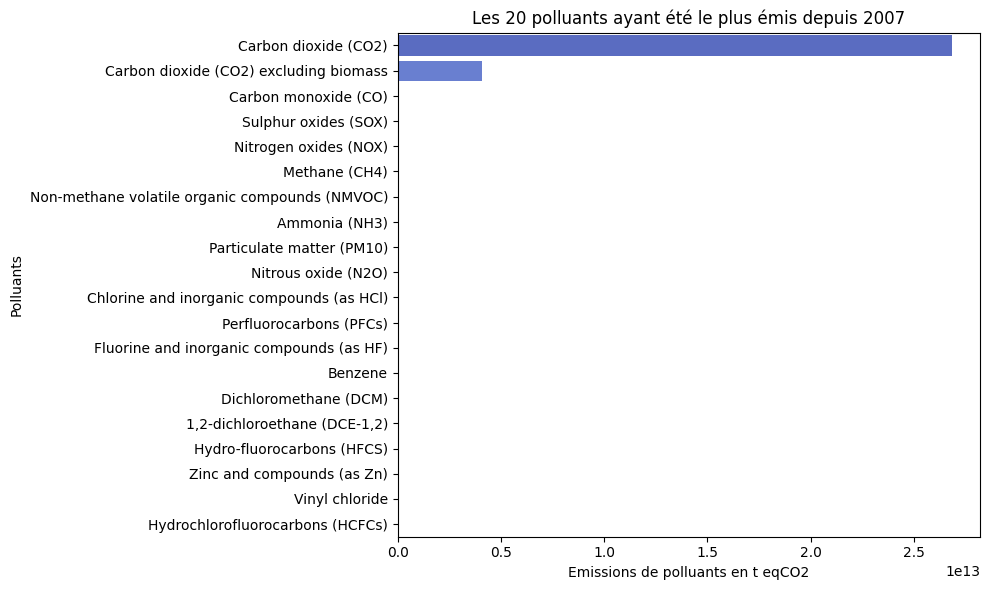

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(data=group_by_pollutant.head(20), x=group_by_pollutant["sum"].head(20), y=group_by_pollutant.index[:20], palette="coolwarm")
plt.title("Les 20 polluants ayant été le plus émis depuis 2007")
plt.xlabel("Emissions de polluants en t eqCO2")
plt.ylabel("Polluants")
plt.tight_layout()
plt.show()

Comparer la quantité totale émise de chacun de ces polluants ne nous fournit pas d'informations utiles, à l'exception du fait que le CO2 est le gaz le plus largement rejeté dans l'atmosphère depuis 2007.

L'idéal, serait de regarder l'évolution de l'émission de polluants au fil des années ou sinon, de corréler ce dataset avec des données comme le Potentiel de Réchauffement Global (PRG) afin d'étudier le degré de dangerosité de chacun de ces gaz à effet de serre (GES).

### GROUP BY YEAR

In [52]:
df.reportingYear.value_counts()

reportingYear
2007    23703
2008    23604
2010    22733
2009    22637
2011    22565
2012    22142
2013    22057
2014    21832
2015    21718
2017    21640
2016    21603
2018    21597
2019    20569
2020    17767
2021    16182
Name: count, dtype: int64

In [53]:
group_by_year = df.groupby(["reportingYear", "pollutant"])["emissions"]\
    .agg(["sum", "mean", "median"])\
    .sort_values(by=["sum"], ascending=False)
group_by_year

sum   
reportingYear pollutant                                               
2007          Carbon dioxide (CO2)                     2.204991e+12  \
2008          Carbon dioxide (CO2)                     2.137824e+12   
2010          Carbon dioxide (CO2)                     2.063704e+12   
2009          Carbon dioxide (CO2)                     1.969666e+12   
2011          Carbon dioxide (CO2)                     1.955836e+12   
...                                                             ...   
              PCDD + PCDF (dioxins + furans) (as Teq)  5.671344e-01   
2012          PCDD + PCDF (dioxins + furans) (as Teq)  4.512370e-01   
2017          Halogenated organic compounds (as AOX)   7.000000e-02   
2012          Brominated diphenylethers (PBDE)         1.800000e-02   
2011          Brominated diphenylethers (PBDE)         2.000000e-03   

                                                               mean   
reportingYear pollutant                                               
2007          Carbon dioxide (CO2)                     9.743661e+08  \
2008          Carbon dioxide (CO2)                     9.214760e+08   
2010          Carbon dioxide (CO2)                     8.830571e+08   
2009          Carbon dioxide (CO2)                     8.757963e+08   
2011          Carbon dioxide (CO2)                     8.488873e+08   
...                                                             ...   
              PCDD + PCDF (dioxins + furans) (as Teq)  2.455127e-03   
2012          PCDD + PCDF (dioxins + furans) (as Teq)  2.290543e-03   
2017          Halogenated organic compounds (as AOX)   7.000000e-02   
2012          Brominated diphenylethers (PBDE)         1.800000e-02   
2011          Brominated diphenylethers (PBDE)         2.000000e-03   

                                                             median  
reportingYear pollutant                                              
2007          Carbon dioxide (CO2)                     3.490000e+08  
2008          Carbon dioxide (CO2)                     3.410000e+08  
2010          Carbon dioxide (CO2)                     3.130000e+08  
2009          Carbon dioxide (CO2)                     3.230000e+08  
2011          Carbon dioxide (CO2)                     3.160000e+08  
...                                                             ...  
              PCDD + PCDF (dioxins + furans) (as Teq)  3.430000e-04  
2012          PCDD + PCDF (dioxins + furans) (as Teq)  3.150000e-04  
2017          Halogenated organic compounds (as AOX)   7.000000e-02  
2012          Brominated diphenylethers (PBDE)         1.800000e-02  
2011          Brominated diphenylethers (PBDE)         2.000000e-03  

[797 rows x 3 columns]

In [54]:
group_by_CO2 = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("CO2")]
group_by_CH4 = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("CH4")]
group_by_N2O = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("N2O")]
group_by_PFCs = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("PFCs")]
group_by_HFCS = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("HFCS")]
group_by_SF6 = group_by_year[group_by_year.index.get_level_values("pollutant").str.contains("SF6")]

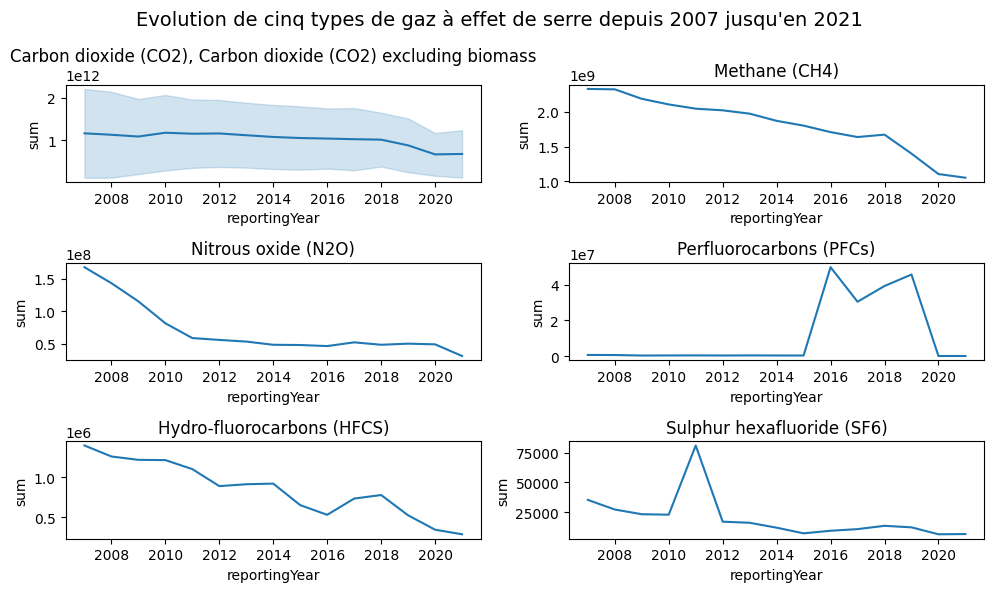

In [55]:
fig = plt.figure(1, figsize=(10, 6), tight_layout=True)

plt.suptitle("Evolution de cinq types de gaz à effet de serre depuis 2007 jusqu'en 2021", fontsize=14)

plt.subplot(321)
plt.title(", ".join(group_by_CO2.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_CO2,
    x=group_by_CO2.index.get_level_values("reportingYear"),
    y=group_by_CO2["sum"]
)

plt.subplot(322)
plt.title(", ".join(group_by_CH4.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_CH4,
    x=group_by_CH4.index.get_level_values("reportingYear"),
    y=group_by_CH4["sum"]
)

plt.subplot(323)
plt.title(", ".join(group_by_N2O.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_N2O,
    x=group_by_N2O.index.get_level_values("reportingYear"),
    y=group_by_N2O["sum"]
)

plt.subplot(324)
plt.title(", ".join(group_by_PFCs.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_PFCs,
    x=group_by_PFCs.index.get_level_values("reportingYear"),
    y=group_by_PFCs["sum"]
)

plt.subplot(325)
plt.title(", ".join(group_by_HFCS.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_HFCS,
    x=group_by_HFCS.index.get_level_values("reportingYear"),
    y=group_by_HFCS["sum"]
)

plt.subplot(326)
plt.title(", ".join(group_by_SF6.index.get_level_values("pollutant").unique()))
sns.lineplot(
    data=group_by_SF6,
    x=group_by_SF6.index.get_level_values("reportingYear"),
    y=group_by_SF6["sum"]
)

plt.show()

Nous avons étudié l'évolution de la quantité de cinq gaz à effet de serre les plus courants : le dioxyde de carbone (CO2), le méthane (CH4), l'oxyde nitreux (N2O), le tétrafluorure de carbone (CF4, PFC-14), le trifluorométhane (CHF3, HFC-23) et l'hexafluorure de soufre (SF6).

Les différents graphiques montrent une diminution globale de ces polluants.

### GROUP BY SECTOR

In [56]:
group_by_sector = df.groupby(["eprtrSectorName", "pollutant"])["emissions"].sum()
group_by_sector

eprtrSectorName                                                  pollutant                    
Animal and vegetable products from the food and beverage sector  Ammonia (NH3)                    1.267974e+07
                                                                 Arsenic and compounds (as As)    3.238000e+02
                                                                 Benzene                          5.705000e+04
                                                                 Cadmium and compounds (as Cd)    4.104000e+02
                                                                 Carbon dioxide (CO2)             1.223143e+11
                                                                                                      ...     
Waste and wastewater management                                  Trichloroethylene (TRI)          1.002520e+06
                                                                 Trichloromethane                 3.172400e+04
                 

In [57]:
group_confidential_by_sector = df_confidential.groupby(["eprtrSectorName", "pollutant"])["emissions"].sum()

In [58]:
group_confidential_by_sector

eprtrSectorName                                                  pollutant                       
Animal and vegetable products from the food and beverage sector  Ammonia (NH3)                       1.063000e+05
                                                                 Carbon dioxide (CO2)                3.763741e+09
                                                                 Chlorofluorocarbons (CFCs)          4.900000e+01
                                                                 Hydro-fluorocarbons (HFCS)          3.030700e+03
                                                                 Hydrochlorofluorocarbons (HCFCs)    3.980000e+02
                                                                                                         ...     
Waste and wastewater management                                  Chlorofluorocarbons (CFCs)          6.837480e+01
                                                                 Hydrochlorofluorocarbons (HCFCs)    9.0

### GROUP BY ACTIVITY

In [59]:
group_by_activity = df.groupby(["EPRTRAnnexIMainActivityLabel", "pollutant"])["emissions"].sum()
group_by_activity

EPRTRAnnexIMainActivityLabel                                                                                                                                                                                                                                    pollutant                    
Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.  1,2-dichloroethane (DCE-1,2)     7.740000e+03
                                                                                                                                                                                                                                                                Ammonia (NH3)                    6.035183e+07
                                                                                                              

In [60]:
group_by_business = df.groupby(["EPRTRAnnexIMainActivityLabel", "pollutant"])["emissions"].sum()
group_by_business

EPRTRAnnexIMainActivityLabel                                                                                                                                                                                                                                    pollutant                    
Chemical installations for the production on an industrial scale of basic inorganic chemicals. Note to reporters, use Level 3 activity e.g. 4(b)(i), in preference to 4(b). Level 2 activity class (i.e. 4(b)) only to be used where Level 3 is not available.  1,2-dichloroethane (DCE-1,2)     7.740000e+03
                                                                                                                                                                                                                                                                Ammonia (NH3)                    6.035183e+07
                                                                                                              

In [62]:
df

countryName                                    eprtrSectorName   
0              Austria                                  Chemical industry  \
1              Austria                                   Other activities   
2              Austria           Paper and wood production and processing   
3              Austria           Paper and wood production and processing   
4              Austria                                   Mineral industry   
...                ...                                                ...   
324550  United Kingdom  Animal and vegetable products from the food an...   
324551  United Kingdom                    Waste and wastewater management   
324552  United Kingdom                    Waste and wastewater management   
324553  United Kingdom     Intensive livestock production and aquaculture   
324554  United Kingdom     Intensive livestock production and aquaculture   

                             EPRTRAnnexIMainActivityLabel   
0       Chemical installations for the production on a...  \
1       Installations for the surface treatment of sub...   
2       Industrial plants for the production of paper ...   
3       Industrial plants for the production of paper ...   
4       Installations for the production of cement cli...   
...                                                   ...   
324550  Treatment and processing intended for the prod...   
324551  Installations for the incineration of non-haza...   
324552  Installations for the incineration of non-haza...   
324553  Installations for the intensive rearing of pou...   
324554  Installations for the intensive rearing of pig...   

                     FacilityInspireID   
0       AT.CAED/9008390392737.FACILITY  \
1       AT.CAED/9008390396414.FACILITY   
2       AT.CAED/9008390397176.FACILITY   
3       AT.CAED/9008390397176.FACILITY   
4       AT.CAED/9008390397220.FACILITY   
...                                ...   
324550      UK.SEPA/200002640.Facility   
324551      UK.SEPA/200002651.Facility   
324552      UK.SEPA/200002651.Facility   
324553      UK.SEPA/200002676.Facility   
324554      UK.SEPA/200002698.Facility   

                                         facilityName   
0                                 Nufarm GmbH & CO KG  \
1                MAGNA STEYR Fahrzeugtechnik AG&Co KG   
2                           Fritz EGGER GmbH & Co. OG   
3                           Fritz EGGER GmbH & Co. OG   
4                              voestalpine Stahl GmbH   
...                                               ...   
324550                        United Biscuits Glasgow   
324551  Millerhill Recycling & Energy Recovery Centre   
324552  Millerhill Recycling & Energy Recovery Centre   
324553       Elrig Farm, Port William, Newton Stewart   
324554                                 Dryfeholm Farm   

                                City   
0                               Linz  \
1              Graz,07.Bez.:Liebenau   
2                      Unterradlberg   
3                      Unterradlberg   
4             Klaus an der Pyhrnbahn   
...                              ...   
324550                       Glasgow   
324551          Millerhill, Dalkeith   
324552          Millerhill, Dalkeith   
324553  Port William, Newton Stewart   
324554                     Locherbie   

                                             pollutant    emissions   
0                         1,2-dichloroethane (DCE-1,2)       3300.0  \
1       Non-methane volatile organic compounds (NMVOC)     170000.0   
2                                 Carbon dioxide (CO2)  228000000.0   
3                                Nitrogen oxides (NOX)     311000.0   
4                                 Carbon dioxide (CO2)  329000000.0   
...                                                ...          ...   
324550                      Hydro-fluorocarbons (HFCS)        330.0   
324551                            Carbon dioxide (CO2)  132000000.0   
324552                           Nitrogen o

### MOST REPRESENTATIVE POLLUTANTS GROUPED BY SECTOR

In [63]:
companies_group_by_sector = df.groupby("eprtrSectorName")["FacilityInspireID"].nunique()

companies_group_by_sector

eprtrSectorName
Animal and vegetable products from the food and beverage sector      954
Chemical industry                                                   1494
Energy sector                                                       2481
Intensive livestock production and aquaculture                     13889
Mineral industry                                                    1905
Other activities                                                     798
Paper and wood production and processing                             504
Production and processing of metals                                 1507
Waste and wastewater management                                     3147
Name: FacilityInspireID, dtype: int64

In [64]:
pollutants_group_by_sector = df.groupby("eprtrSectorName")["pollutant"]

In [65]:
pollutants_group_by_sector.describe()

count unique   
eprtrSectorName                                                    
Animal and vegetable products from the food and...   6610     30  \
Chemical industry                                   24101     56   
Energy sector                                       80132     52   
Intensive livestock production and aquaculture      92881     14   
Mineral industry                                    35246     40   
Other activities                                     5413     48   
Paper and wood production and processing            13223     39   
Production and processing of metals                 27621     53   
Waste and wastewater management                     36108     59   

                                                                                               top   
eprtrSectorName                                                                                      
Animal and vegetable products from the food and...                      Hydro-fluorocarbons (HFCS)  \
Chemical industry                                   Non-methane volatile organic compounds (NMVOC)   
Energy sector                                                                Nitrogen oxides (NOX)   
Intensive livestock production and aquaculture                                       Ammonia (NH3)   
Mineral industry                                                             Nitrogen oxides (NOX)   
Other activities                                    Non-methane volatile organic compounds (NMVOC)   
Paper and wood production and processing                                     Nitrogen oxides (NOX)   
Production and processing of metals                                     Zinc and compounds (as Zn)   
Waste and wastewater management                                                      Methane (CH4)   

                                                     freq  
eprtrSectorName                                            
Animal and vegetable products from the food and...   1166  
Chemical industry                                    3005  
Energy sector                                       15969  
Intensive livestock production and aquaculture      88945  
Mineral industry                                     8187  
Other activities                                     3574  
Paper and wood production and processing             3038  
Production and processing of metals                  3101  
Waste and wastewater management                     14873

In [66]:
emissions_of_pollutants_group_by_sector = df.groupby(["eprtrSectorName", "pollutant"])
emissions_of_pollutants_group_by_sector["emissions"].describe()

count   
eprtrSectorName                                    pollutant                              
Animal and vegetable products from the food and... Ammonia (NH3)                  356.0  \
                                                   Arsenic and compounds (as As)    5.0   
                                                   Benzene                         34.0   
                                                   Cadmium and compounds (as Cd)   14.0   
                                                   Carbon dioxide (CO2)           664.0   
...                                                                                 ...   
Waste and wastewater management                    Trichloroethylene (TRI)         13.0   
                                                   Trichloromethane                25.0   
                                                   Vinyl chloride                  17.0   
                                                   Xylenes                          1.0   
                                                   Zinc and compounds (as Zn)     326.0   

                                                                                          mean   
eprtrSectorName                                    pollutant                                     
Animal and vegetable products from the food and... Ammonia (NH3)                  3.561726e+04  \
                                                   Arsenic and compounds (as As)  6.476000e+01   
                                                   Benzene                        1.677941e+03   
                                                   Cadmium and compounds (as Cd)  2.931429e+01   
                                                   Carbon dioxide (CO2)           1.842083e+08   
...                                                                                        ...   
Waste and wastewater management                    Trichloroethylene (TRI)        7.711692e+04   
                                                   Trichloromethane               1.268960e+03   
                                                   Vinyl chloride                 3.085859e+04   
                                                   Xylenes                        6.040000e+03   
                                                   Zinc and compounds (as Zn)     6.863458e+02   

                                                                                           std   
eprtrSectorName                                    pollutant                                     
Animal and vegetable products from the food and... Ammonia (NH3)                  3.186598e+04  \
                                                   Arsenic and compounds (as As)  5.183462e+01   
                                                   Benzene                        5.821214e+02   
                                                   Cadmium and compounds (as Cd)  2.019184e+01   
                                                   Carbon dioxide (CO2)           1.434349e+08   
...                                                                                        ...   
Waste and wastewater management                    Trichloroethylene (TRI)        7.982327e+04   
                                                   Trichloromethane               1.029192e+03   
                                                   Vinyl chloride                 3.447619e+04   
                                                   Xylenes                                 NaN   
                                                   Zinc and compounds (as Zn)     9.495019e+02   

                                                                                      min   
eprtrSectorName                                    pollutant                                
Animal and vegetable products from the food and... Ammonia (NH3)                      0.0  \
                                                   Arsenic and compou

In [67]:
pollutant_group_by_sector = df.groupby(["reportingYear", "eprtrSectorName", "pollutant"])["emissions"]\
    .agg(["sum", "mean", "median"])\
    .sort_values(by=["sum"], ascending=False)

In [68]:
pollutant_group_by_sector

sum   
reportingYear eprtrSectorName                                    pollutant                                               
2007          Energy sector                                      Carbon dioxide (CO2)                     1.561867e+12  \
2008          Energy sector                                      Carbon dioxide (CO2)                     1.508504e+12   
2010          Energy sector                                      Carbon dioxide (CO2)                     1.476674e+12   
2009          Energy sector                                      Carbon dioxide (CO2)                     1.446421e+12   
2011          Energy sector                                      Carbon dioxide (CO2)                     1.371601e+12   
...                                                                                                                ...   
2016          Animal and vegetable products from the food and... PCDD + PCDF (dioxins + furans) (as Teq)  2.400000e-04   
              Chemical industry                                  Toluene                                  2.000000e-04   
2019          Other activities                                   PCDD + PCDF (dioxins + furans) (as Teq)  1.280000e-04   
2020          Waste and wastewater management                    Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   
2021          Waste and wastewater management                    Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   

                                                                                                                  mean   
reportingYear eprtrSectorName                                    pollutant                                               
2007          Energy sector                                      Carbon dioxide (CO2)                     1.400778e+09  \
2008          Energy sector                                      Carbon dioxide (CO2)                     1.329078e+09   
2010          Energy sector                                      Carbon dioxide (CO2)                     1.284064e+09   
2009          Energy sector                                      Carbon dioxide (CO2)                     1.283426e+09   
2011          Energy sector                                      Carbon dioxide (CO2)                     1.252604e+09   
...                                                                                                                ...   
2016          Animal and vegetable products from the food and... PCDD + PCDF (dioxins + furans) (as Teq)  2.400000e-04   
              Chemical industry                                  Toluene                                  2.000000e-04   
2019          Other activities                                   PCDD + PCDF (dioxins + furans) (as Teq)  1.280000e-04   
2020          Waste and wastewater management                    Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   
2021          Waste and wastewater management                    Di-(2-ethyl hexyl) phthalate (DEHP)      0.000000e+00   

                                                                                                                median  
reportingYear eprtrSectorName                                    pollutant                                              
2007          Energy sector                                      Carbon dioxide (CO2)                     5.310000e+08  
2008          Energy sector                                      Carbon dioxide (CO2)                     5.190000e+08  
2010          Energy sector                                      Carbon dioxide (CO2)                     4.470000e+08  
2009          Energy sector                                      Carbon dioxide (CO2)                     4.740000e+08  
2011          Energy sector                                      Carbon dioxide (CO2)                     4.680000e+08  
...                                                                                           

In [69]:
co2_data = pollutant_group_by_sector[pollutant_group_by_sector.index.get_level_values("pollutant") == "Carbon dioxide (CO2)"]
co2_data

sum   
reportingYear eprtrSectorName                                pollutant                            
2007          Energy sector                                  Carbon dioxide (CO2)  1.561867e+12  \
2008          Energy sector                                  Carbon dioxide (CO2)  1.508504e+12   
2010          Energy sector                                  Carbon dioxide (CO2)  1.476674e+12   
2009          Energy sector                                  Carbon dioxide (CO2)  1.446421e+12   
2011          Energy sector                                  Carbon dioxide (CO2)  1.371601e+12   
...                                                                                         ...   
2016          Intensive livestock production and aquaculture Carbon dioxide (CO2)  6.910000e+08   
2018          Other activities                               Carbon dioxide (CO2)  6.721656e+08   
2009          Other activities                               Carbon dioxide (CO2)  6.045000e+08   
2010          Other activities                               Carbon dioxide (CO2)  6.026000e+08   
2013          Intensive livestock production and aquaculture Carbon dioxide (CO2)  1.720000e+08   

                                                                                           mean   
reportingYear eprtrSectorName                                pollutant                            
2007          Energy sector                                  Carbon dioxide (CO2)  1.400778e+09  \
2008          Energy sector                                  Carbon dioxide (CO2)  1.329078e+09   
2010          Energy sector                                  Carbon dioxide (CO2)  1.284064e+09   
2009          Energy sector                                  Carbon dioxide (CO2)  1.283426e+09   
2011          Energy sector                                  Carbon dioxide (CO2)  1.252604e+09   
...                                                                                         ...   
2016          Intensive livestock production and aquaculture Carbon dioxide (CO2)  6.910000e+08   
2018          Other activities                               Carbon dioxide (CO2)  9.602365e+07   
2009          Other activities                               Carbon dioxide (CO2)  1.209000e+08   
2010          Other activities                               Carbon dioxide (CO2)  1.506500e+08   
2013          Intensive livestock production and aquaculture Carbon dioxide (CO2)  1.720000e+08   

                                                                                        median  
reportingYear eprtrSectorName                                pollutant                          
2007          Energy sector                                  Carbon dioxide (CO2)  531000000.0  
2008          Energy sector                                  Carbon dioxide (CO2)  519000000.0  
2010          Energy sector                                  Carbon dioxide (CO2)  447000000.0  
2009          Energy sector                                  Carbon dioxide (CO2)  474000000.0  
2011          Energy sector                                  Carbon dioxide (CO2)  468000000.0  
...                                                                                        ...  
2016          Intensive livestock production and aquaculture Carbon dioxide (CO2)  691000000.0  
2018          Other activities                               Carbon dioxide (CO2)   25800000.0  
2009          Other activities                               Carbon dioxide (CO2)  117000000.0  
2010          Other activities                               Carbon dioxide (CO2)  159000000.0  
2013          Intensive livestock production and aquaculture Carbon dioxide (CO2)  172000000.0  

[125 rows x 3 columns]

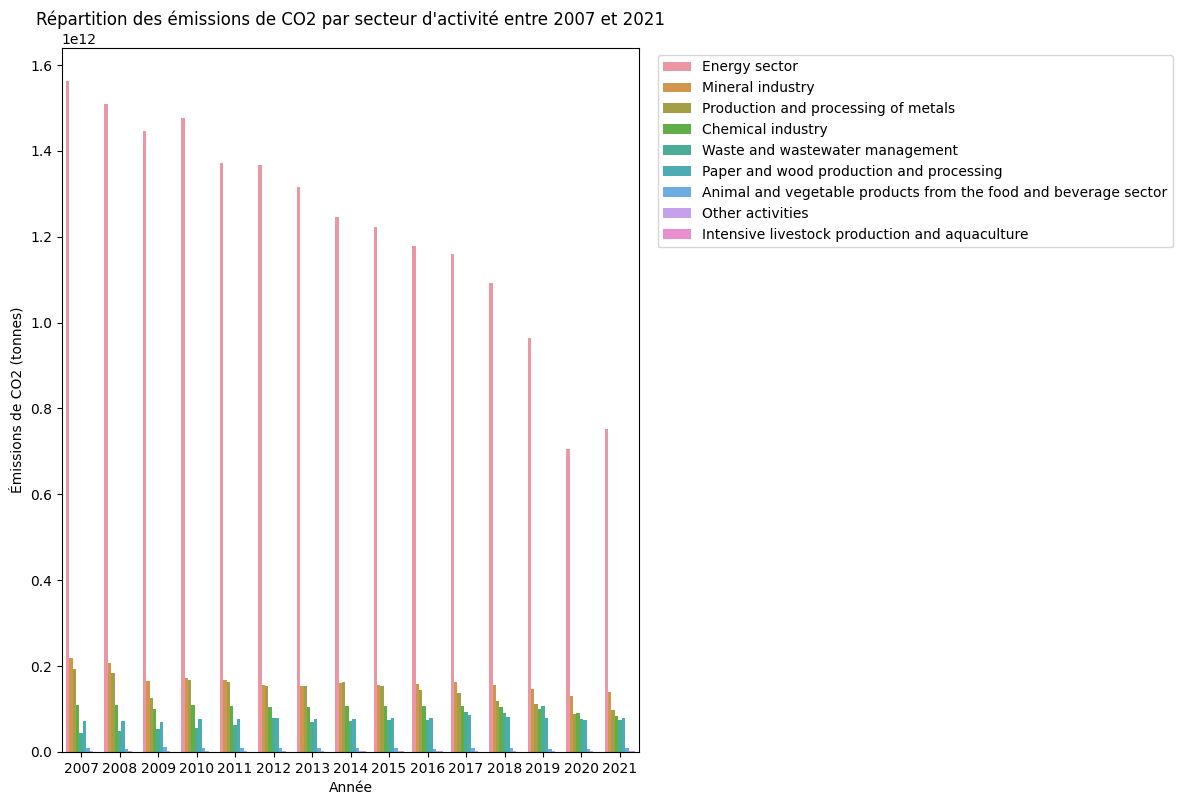

In [70]:
co2_data = co2_data.reset_index()

plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.barplot(data=co2_data, x="reportingYear", y="sum", hue="eprtrSectorName")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (tonnes)")
plt.title("Répartition des émissions de CO2 par secteur d'activité entre 2007 et 2021")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

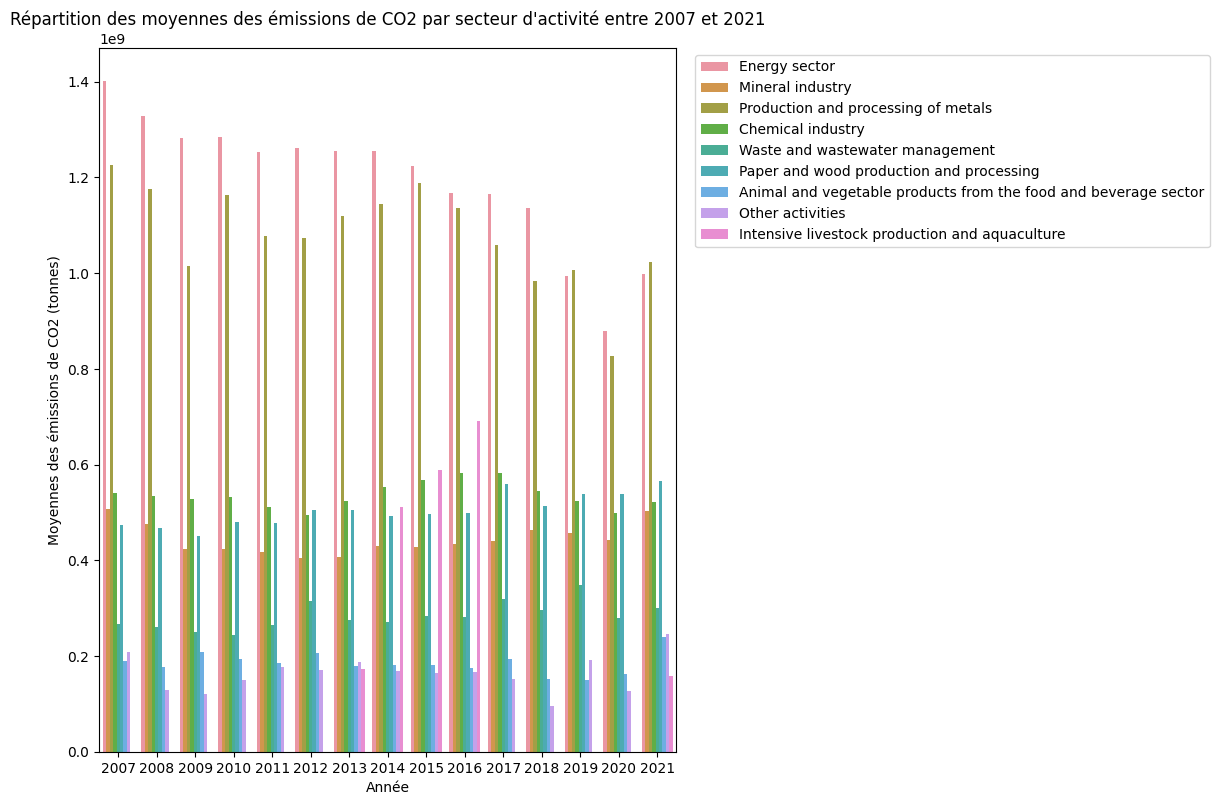

In [71]:
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.barplot(data=co2_data, x="reportingYear", y="mean", hue="eprtrSectorName")
plt.xlabel("Année")
plt.ylabel("Moyennes des émissions de CO2 (tonnes)")
plt.title("Répartition des moyennes des émissions de CO2 par secteur d'activité entre 2007 et 2021")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

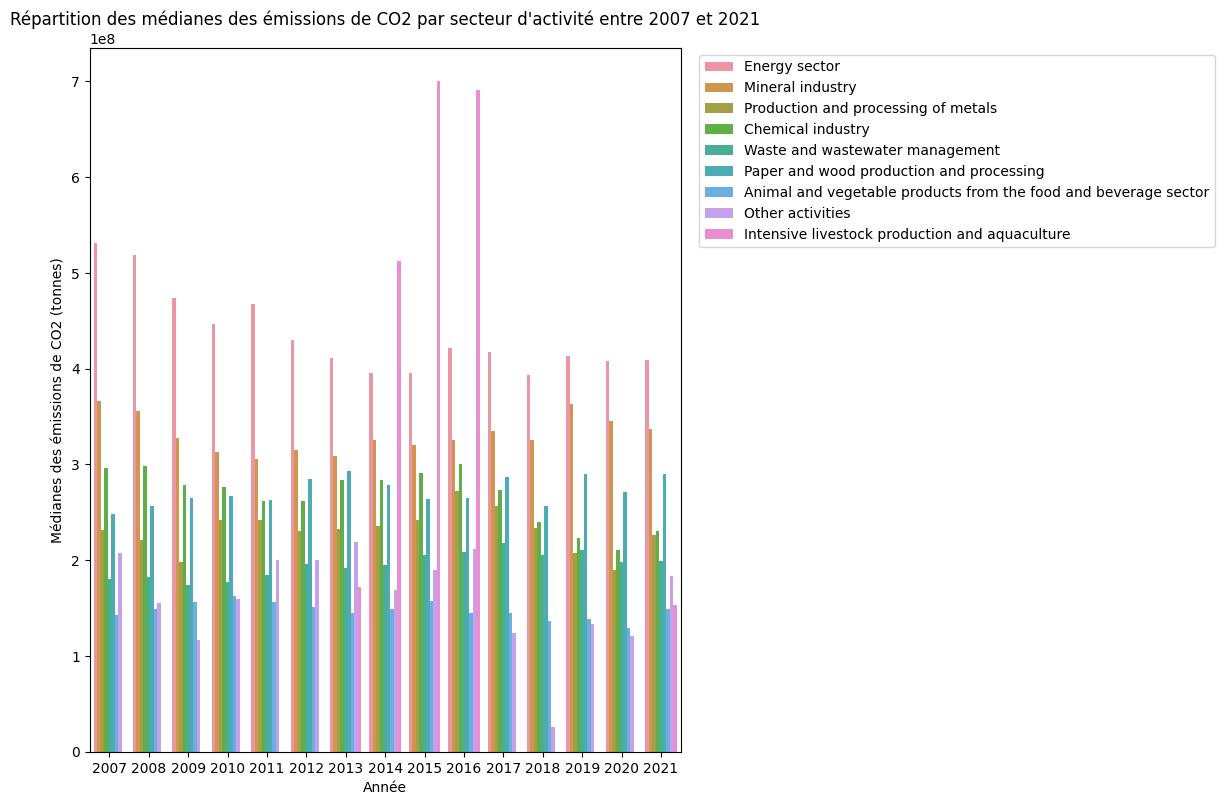

In [72]:
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.barplot(data=co2_data, x="reportingYear", y="median", hue="eprtrSectorName")
plt.xlabel("Année")
plt.ylabel("Médianes des émissions de CO2 (tonnes)")
plt.title("Répartition des médianes des émissions de CO2 par secteur d'activité entre 2007 et 2021")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

La médiane du secteur Intensive livestock production and aquaculture en ce qui concerne les émissions de CO2 est aussi élevée car il n'y a que 13 entrées basées sur ce polluant dans ce secteur.

In [73]:
emissions_of_pollutants_group_by_sector = emissions_of_pollutants_group_by_sector["emissions"].aggregate(
    ["count", "sum", "median", "mean"])
emissions_of_pollutants_group_by_sector

count   
eprtrSectorName                                    pollutant                              
Animal and vegetable products from the food and... Ammonia (NH3)                    356  \
                                                   Arsenic and compounds (as As)      5   
                                                   Benzene                           34   
                                                   Cadmium and compounds (as Cd)     14   
                                                   Carbon dioxide (CO2)             664   
...                                                                                 ...   
Waste and wastewater management                    Trichloroethylene (TRI)           13   
                                                   Trichloromethane                  25   
                                                   Vinyl chloride                    17   
                                                   Xylenes                            1   
                                                   Zinc and compounds (as Zn)       326   

                                                                                           sum   
eprtrSectorName                                    pollutant                                     
Animal and vegetable products from the food and... Ammonia (NH3)                  1.267974e+07  \
                                                   Arsenic and compounds (as As)  3.238000e+02   
                                                   Benzene                        5.705000e+04   
                                                   Cadmium and compounds (as Cd)  4.104000e+02   
                                                   Carbon dioxide (CO2)           1.223143e+11   
...                                                                                        ...   
Waste and wastewater management                    Trichloroethylene (TRI)        1.002520e+06   
                                                   Trichloromethane               3.172400e+04   
                                                   Vinyl chloride                 5.245960e+05   
                                                   Xylenes                        6.040000e+03   
                                                   Zinc and compounds (as Zn)     2.237487e+05   

                                                                                       median   
eprtrSectorName                                    pollutant                                    
Animal and vegetable products from the food and... Ammonia (NH3)                      23050.0  \
                                                   Arsenic and compounds (as As)         31.6   
                                                   Benzene                             1545.0   
                                                   Cadmium and compounds (as Cd)         21.3   
                                                   Carbon dioxide (CO2)           147000000.0   
...                                                                                       ...   
Waste and wastewater management                    Trichloroethylene (TRI)            53000.0   
                                                   Trichloromethane                     800.0   
                                                   Vinyl chloride                     13600.0   
                                                   Xylenes                             6040.0   
                                                   Zinc and compounds (as Zn)           310.0   

                                                                                          mean  
eprtrSectorName                                    pollutant                                    
Animal and vegetable products from the food and... Ammonia (NH3)                  3.561726e+04  
                                                   Arsenic and compoun

In [74]:
emissions_of_pollutants_group_by_sector = emissions_of_pollutants_group_by_sector[
    emissions_of_pollutants_group_by_sector.index.get_level_values("pollutant") != "CONFIDENTIAL"]

In [75]:
print("Nombre d'enregistrement total :", emissions_of_pollutants_group_by_sector["count"].sum())
print("Nombre de polluant total :", len(df.pollutant.unique()))

Nombre d'enregistrement total : 321335
Nombre de polluant total : 67


In [76]:
count_pollutant_over36 = emissions_of_pollutants_group_by_sector[emissions_of_pollutants_group_by_sector["count"] >= 36]
print("Nombre d'enregistrement restant :", count_pollutant_over36["count"].sum())
print("Nombre de polluant restant :", len(
    count_pollutant_over36\
    .groupby("pollutant")[["count", "sum"]]\
    .sum()\
    .sort_values(by=["count"])
))

Nombre d'enregistrement restant : 319870
Nombre de polluant restant : 50


In [77]:
emissions_of_pollutants_group_by_sector.groupby("eprtrSectorName")[["count", "sum"]].sum()

count           sum
eprtrSectorName                                                        
Animal and vegetable products from the food and...   6610  1.368202e+11
Chemical industry                                   24101  1.760624e+12
Energy sector                                       80132  2.147520e+13
Intensive livestock production and aquaculture      92881  7.920082e+09
Mineral industry                                    35246  2.795848e+12
Other activities                                     5413  1.697666e+10
Paper and wood production and processing            13223  1.228365e+12
Production and processing of metals                 27621  2.465562e+12
Waste and wastewater management                     36108  1.204381e+12

In [78]:
count_pollutant_over36.groupby("eprtrSectorName")[["count", "sum"]].sum()

count           sum
eprtrSectorName                                                        
Animal and vegetable products from the food and...   6411  1.368201e+11
Chemical industry                                   23947  1.760623e+12
Energy sector                                       79836  2.147520e+13
Intensive livestock production and aquaculture      92834  3.315014e+09
Mineral industry                                    35194  2.795848e+12
Other activities                                     5162  1.631819e+10
Paper and wood production and processing            13115  1.228364e+12
Production and processing of metals                 27520  2.465562e+12
Waste and wastewater management                     35851  1.204379e+12

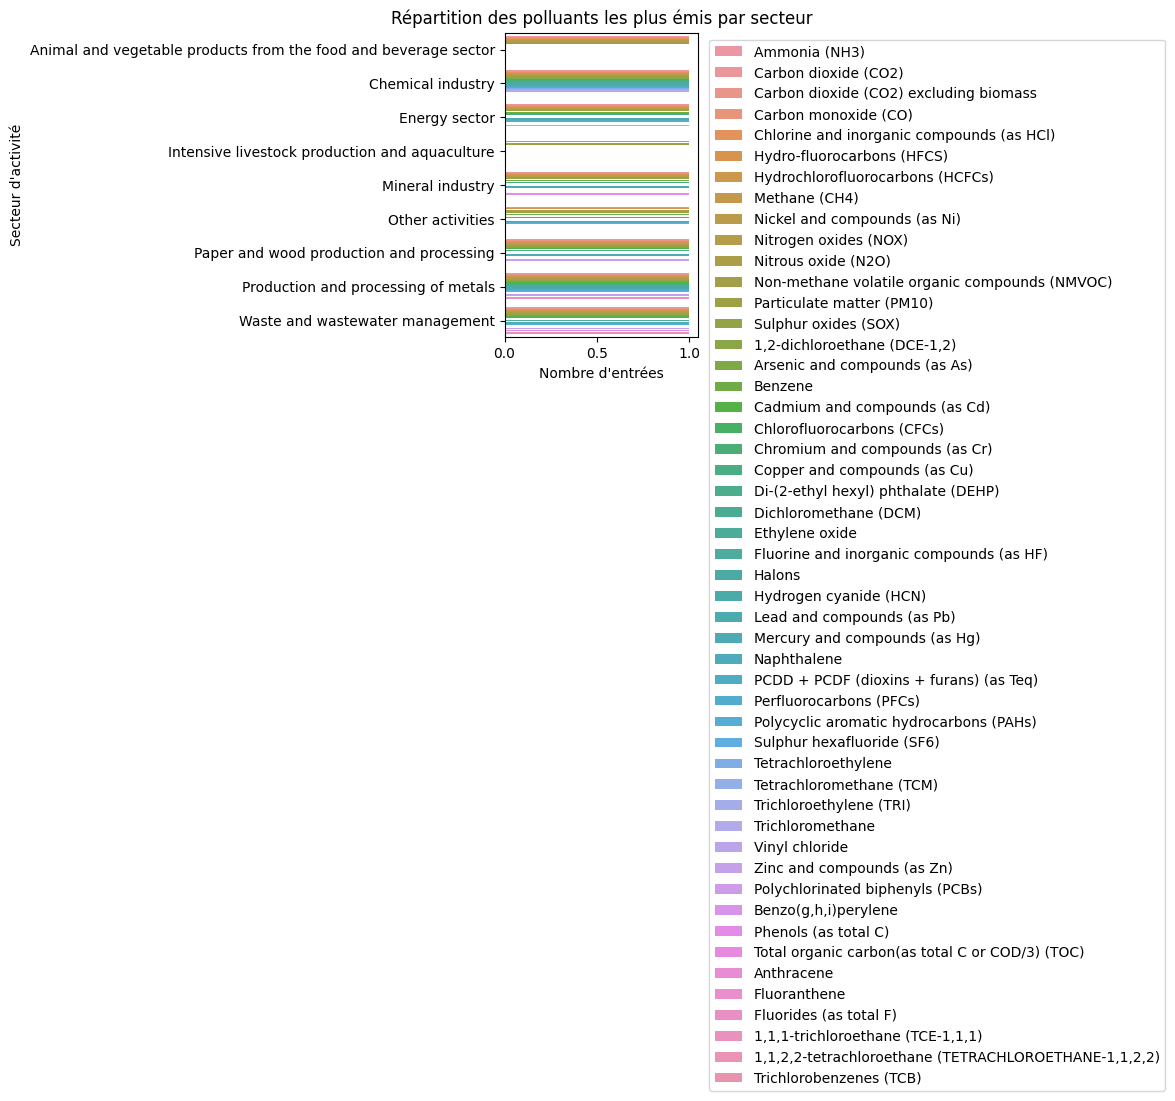

In [79]:
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")

sns.countplot(
    data=count_pollutant_over36, 
    y=count_pollutant_over36.index.get_level_values("eprtrSectorName"),
    hue=count_pollutant_over36.index.get_level_values("pollutant"),
)
plt.xlabel("Nombre d'entrées")
plt.ylabel("Secteur d'activité")
plt.title("Répartition des polluants les plus émis par secteur")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [80]:
count_pollutant_over36

count   
eprtrSectorName                                    pollutant                                                
Animal and vegetable products from the food and... Ammonia (NH3)                                      356  \
                                                   Carbon dioxide (CO2)                               664   
                                                   Carbon dioxide (CO2) excluding biomass              96   
                                                   Carbon monoxide (CO)                               192   
                                                   Chlorine and inorganic compounds (as HCl)          135   
...                                                                                                   ...   
Waste and wastewater management                    Polycyclic aromatic hydrocarbons (PAHs)             43   
                                                   Sulphur oxides (SOX)                               281   
                                                   Total organic carbon(as total C or COD/3) (TOC)    156   
                                                   Trichlorobenzenes (TCB)                             72   
                                                   Zinc and compounds (as Zn)                         326   

                                                                                                             sum   
eprtrSectorName                                    pollutant                                                       
Animal and vegetable products from the food and... Ammonia (NH3)                                    1.267974e+07  \
                                                   Carbon dioxide (CO2)                             1.223143e+11   
                                                   Carbon dioxide (CO2) excluding biomass           1.357212e+10   
                                                   Carbon monoxide (CO)                             1.850322e+08   
                                                   Chlorine and inorganic compounds (as HCl)        2.096854e+06   
...                                                                                                          ...   
Waste and wastewater management                    Polycyclic aromatic hydrocarbons (PAHs)          2.825845e+04   
                                                   Sulphur oxides (SOX)                             1.406129e+08   
                                                   Total organic carbon(as total C or COD/3) (TOC)  1.152943e+05   
                                                   Trichlorobenzenes (TCB)                          2.303600e+03   
                                                   Zinc and compounds (as Zn)                       2.237487e+05   

                                                                                                         median   
eprtrSectorName                                    pollutant                                                      
Animal and vegetable products from the food and... Ammonia (NH3)                                        23050.0  \
                                                   Carbon dioxide (CO2)                             147000000.0   
                                                   Carbon dioxide (CO2) excluding biomass           124000000.0   
                                                   Carbon monoxide (CO)                                696000.0   
                                                   Chlorine and inorganic compounds (as HCl)            15800.0   
...                                                                                                         ...   
Waste and wastewater management                    Polycyclic aromatic hydrocarbons (PAHs)                102.0   
                                                   Sulphur oxides (SOX)                                214000.0   
                       

/tmp/ipykernel_513/3887985918.py:24: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



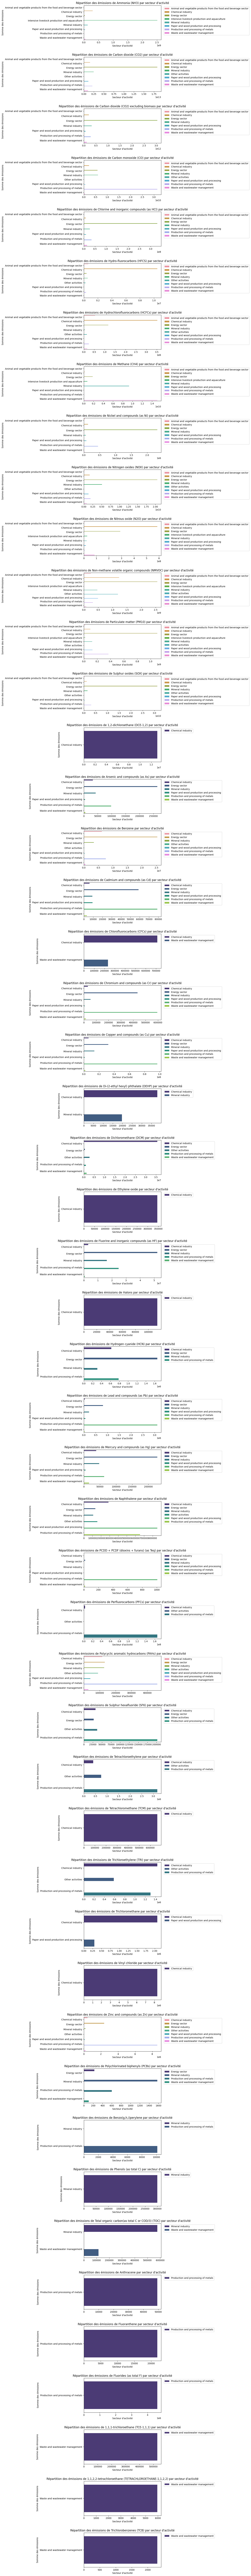

In [81]:
pollutants = count_pollutant_over36.index.get_level_values("pollutant").unique()

num_pollutants = len(pollutants)
fig, axes = plt.subplots(num_pollutants, 1, figsize=(6, num_pollutants*4), facecolor='white')

plt.subplots_adjust(hspace=0.5)

for i, pollutant in enumerate(pollutants):
    data = count_pollutant_over36[count_pollutant_over36.index.get_level_values("pollutant") == pollutant]

    ax = axes[i]
    sns.barplot(
        data=data.reset_index(),
        x="sum",
        y="eprtrSectorName",
        hue="eprtrSectorName",
        ax=ax
    )
    ax.set_xlabel("Secteur d'activité")
    ax.set_ylabel("Somme des émissions")
    ax.set_title(f"Répartition des émissions de {pollutant} par secteur d'activité")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()

plt.show()

## Data processing

In [82]:
len(df)

322349

In [83]:
df = df[df.pollutant != "CONFIDENTIAL"]
len(df)

322349

In [84]:
df = df.merge(count_pollutant_over36, left_on=["eprtrSectorName", "pollutant"], right_index=True, how="inner")
df.head()

countryName    eprtrSectorName   
0       Austria  Chemical industry  \
220     Austria  Chemical industry   
436     Austria  Chemical industry   
641     Austria  Chemical industry   
852     Austria  Chemical industry   

                          EPRTRAnnexIMainActivityLabel   
0    Chemical installations for the production on a...  \
220  Chemical installations for the production on a...   
436  Chemical installations for the production on a...   
641  Chemical installations for the production on a...   
852  Chemical installations for the production on a...   

                  FacilityInspireID         facilityName  City   
0    AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz  \
220  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   
436  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   
641  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   
852  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   

                        pollutant  emissions  reportingYear  count   
0    1,2-dichloroethane (DCE-1,2)     3300.0           2007    328  \
220  1,2-dichloroethane (DCE-1,2)     3310.0           2008    328   
436  1,2-dichloroethane (DCE-1,2)     2550.0           2009    328   
641  1,2-dichloroethane (DCE-1,2)     3220.0           2010    328   
852  1,2-dichloroethane (DCE-1,2)     2820.0           2011    328   

            sum  median         mean  
0    13083822.0  8675.0  39889.70122  
220  13083822.0  8675.0  39889.70122  
436  13083822.0  8675.0  39889.70122  
641  13083822.0  8675.0  39889.70122  
852  13083822.0  8675.0  39889.70122

In [85]:
len(df.pollutant.unique())

50

In [86]:
df.pollutant.unique()

array(['1,2-dichloroethane (DCE-1,2)',
       'Non-methane volatile organic compounds (NMVOC)',
       'Carbon dioxide (CO2)', 'Nitrogen oxides (NOX)',
       'Sulphur oxides (SOX)', 'Zinc and compounds (as Zn)',
       'Carbon monoxide (CO)', 'Methane (CH4)',
       'Mercury and compounds (as Hg)', 'Hydrogen cyanide (HCN)',
       'Particulate matter (PM10)', 'Nitrous oxide (N2O)',
       'Hydrochlorofluorocarbons (HCFCs)',
       'Chromium and compounds (as Cr)', 'Copper and compounds (as Cu)',
       'Lead and compounds (as Pb)',
       'Chlorine and inorganic compounds (as HCl)', 'Ammonia (NH3)',
       'Benzene', 'Polycyclic aromatic hydrocarbons (PAHs)',
       'Dichloromethane (DCM)', 'Cadmium and compounds (as Cd)',
       'Nickel and compounds (as Ni)',
       'PCDD + PCDF (dioxins + furans) (as Teq)',
       'Hydro-fluorocarbons (HFCS)',
       'Fluorine and inorganic compounds (as HF)', 'Naphthalene',
       'Arsenic and compounds (as As)', 'Sulphur hexafluoride (SF6)',
    

In [87]:
df.pollutant.value_counts()

pollutant
Ammonia (NH3)                                            95388
Nitrogen oxides (NOX)                                    36934
Carbon dioxide (CO2)                                     32375
Methane (CH4)                                            22789
Sulphur oxides (SOX)                                     17075
Non-methane volatile organic compounds (NMVOC)           12896
Nitrous oxide (N2O)                                       8795
Carbon monoxide (CO)                                      8016
Particulate matter (PM10)                                 7323
Mercury and compounds (as Hg)                             6559
Hydrochlorofluorocarbons (HCFCs)                          6550
Zinc and compounds (as Zn)                                6137
Carbon dioxide (CO2) excluding biomass                    5990
Chlorine and inorganic compounds (as HCl)                 5934
Nickel and compounds (as Ni)                              5636
Hydro-fluorocarbons (HFCS)                   

In [88]:
group_by_sector_pollutant = df.groupby(["eprtrSectorName", "pollutant"])["emissions"]\
    .quantile(q=[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.99])

In [89]:
group_by_sector_pollutant = group_by_sector_pollutant.unstack().stack().reset_index()
group_by_sector_pollutant = group_by_sector_pollutant.rename(columns={"level_2": "category", 0: "thresholdCategory"})
group_by_sector_pollutant.head(8)

eprtrSectorName      pollutant  category   
0  Animal and vegetable products from the food an...  Ammonia (NH3)     0.125  \
1  Animal and vegetable products from the food an...  Ammonia (NH3)     0.250   
2  Animal and vegetable products from the food an...  Ammonia (NH3)     0.375   
3  Animal and vegetable products from the food an...  Ammonia (NH3)     0.500   
4  Animal and vegetable products from the food an...  Ammonia (NH3)     0.625   
5  Animal and vegetable products from the food an...  Ammonia (NH3)     0.750   
6  Animal and vegetable products from the food an...  Ammonia (NH3)     0.875   
7  Animal and vegetable products from the food an...  Ammonia (NH3)     0.990   

   thresholdCategory  
0            12000.0  
1            14500.0  
2            17912.5  
3            23050.0  
4            34500.0  
5            49825.0  
6            61987.5  
7           162700.0

In [90]:
df[
    (df.eprtrSectorName == "Animal and vegetable products from the food and beverage sector") &
    (df.pollutant == "Carbon dioxide (CO2)") &
    (df.emissions > 6.585500e+08)
]["emissions"].describe()

count    7.000000e+00
mean     1.100714e+09
std      3.138422e+08
min      7.760000e+08
25%      9.625000e+08
50%      9.940000e+08
75%      1.125000e+09
max      1.760000e+09
Name: emissions, dtype: float64

In [91]:
def get_category(sector: str, pollutant: str, emission: float, return_col: str, last_elem: int = -1) -> float:
    subset = group_by_sector_pollutant[
        (group_by_sector_pollutant.eprtrSectorName == sector) &
        (group_by_sector_pollutant.pollutant == pollutant) &
        (group_by_sector_pollutant.thresholdCategory < emission)
    ][return_col] 

    return subset.iloc[last_elem] if len(subset) > 0 else 0.0

In [92]:
df["category"] = df.apply(
    lambda x: get_category(
        x["eprtrSectorName"], 
        x["pollutant"], 
        x["emissions"], 
        "category"
    ),
    axis=1
)

In [93]:
df.head()

countryName    eprtrSectorName   
0       Austria  Chemical industry  \
220     Austria  Chemical industry   
436     Austria  Chemical industry   
641     Austria  Chemical industry   
852     Austria  Chemical industry   

                          EPRTRAnnexIMainActivityLabel   
0    Chemical installations for the production on a...  \
220  Chemical installations for the production on a...   
436  Chemical installations for the production on a...   
641  Chemical installations for the production on a...   
852  Chemical installations for the production on a...   

                  FacilityInspireID         facilityName  City   
0    AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz  \
220  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   
436  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   
641  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   
852  AT.CAED/9008390392737.FACILITY  Nufarm GmbH & CO KG  Linz   

                        pollutant  emissions  reportingYear  count   
0    1,2-dichloroethane (DCE-1,2)     3300.0           2007    328  \
220  1,2-dichloroethane (DCE-1,2)     3310.0           2008    328   
436  1,2-dichloroethane (DCE-1,2)     2550.0           2009    328   
641  1,2-dichloroethane (DCE-1,2)     3220.0           2010    328   
852  1,2-dichloroethane (DCE-1,2)     2820.0           2011    328   

            sum  median         mean  category  
0    13083822.0  8675.0  39889.70122     0.250  
220  13083822.0  8675.0  39889.70122     0.250  
436  13083822.0  8675.0  39889.70122     0.125  
641  13083822.0  8675.0  39889.70122     0.250  
852  13083822.0  8675.0  39889.70122     0.125

TODO
- Voir activité si même référentiel
- Voir doublon, etc.... Est-ce utile ?

- PRG ?

- Analyser le polluant Total Organic Carbon (TOC) : https://en.wikipedia.org/wiki/Total_organic_carbon

In [94]:
df[df.pollutant == "Hydro-fluorocarbons (HFCS)"]["emissions"].describe()

count      4634.000000
mean       2752.493802
std       18591.860440
min           0.000000
25%         170.000000
50%         323.500000
75%         894.850000
max      419000.000000
Name: emissions, dtype: float64

In [95]:
df[(df.pollutant == "Hydro-fluorocarbons (HFCS)") & (df.emissions > 100_000)]

countryName    eprtrSectorName   
2894       Belgium  Chemical industry  \
3716       Belgium  Chemical industry   
4527       Belgium  Chemical industry   
5238       Belgium  Chemical industry   
5975       Belgium  Chemical industry   
6747       Belgium  Chemical industry   
10559      Belgium  Chemical industry   
11089      Belgium  Chemical industry   
45735       France  Chemical industry   
45982       France  Chemical industry   
55981       France  Chemical industry   
58694       France  Chemical industry   
61412       France  Chemical industry   
63940       France  Chemical industry   
66283       France  Chemical industry   
80958      Germany  Chemical industry   
83748      Germany  Chemical industry   
86648      Germany  Chemical industry   
89546      Germany  Chemical industry   
92496      Germany  Chemical industry   
98423      Germany  Chemical industry   
101322     Germany  Chemical industry   
109614     Germany  Chemical industry   
112237     Germany  Chemical industry   
240411       Spain  Chemical industry   

                             EPRTRAnnexIMainActivityLabel   
2894    Chemical installations for the production on a...  \
3716    Chemical installations for the production on a...   
4527    Chemical installations for the production on a...   
5238    Chemical installations for the production on a...   
5975    Chemical installations for the production on a...   
6747    Chemical installations for the production on a...   
10559   Chemical installations for the production on a...   
11089   Chemical installations for the production on a...   
45735   Chemical installations for the production on a...   
45982   Chemical installations for the production on a...   
55981   Chemical installations for the production on a...   
58694   Chemical installations for the production on a...   
61412   Chemical installations for the production on a...   
63940   Chemical installations for the production on a...   
66283   Chemical installations for the production on a...   
80958   Chemical installations for the production on a...   
83748   Chemical installations for the production on a...   
86648   Chemical installations for the production on a...   
89546   Chemical installations for the production on a...   
92496   Chemical installations for the production on a...   
98423   Chemical installations for the production on a...   
101322  Chemical installations for the production on a...   
109614  Chemical installations for the production on a...   
112237  Chemical installations for the production on a...   
240411  Chemical installations for the production on a...   

                                        FacilityInspireID   
2894                                BE.EEA/14650.FACILITY  \
3716                                BE.EEA/14650.FACILITY   
4527                                BE.EEA/14650.FACILITY   
5238                                BE.EEA/14650.FACILITY   
5975                                BE.EEA/14650.FACILITY   
6747                                BE.EEA/14650.FACILITY   
10559   https://data.ied_registry.omgeving.vlaanderen....   
11089   https://data.ied_registry.omgeving.vlaanderen....   
45735                               FR.CAED/9144.FACILITY   
45982                                FR.EEA/1141.FACILITY   
55981                               FR.CAED/3833.FACILITY   
58694                               FR.CAED/3833.FACILITY   
61412                               FR.CAED/3833.FACILITY   
63940                               FR.CAED/3833.FACILITY   
66283                               FR.CAED/3833.FACILITY   
80958   https://registry.gdi-de.org/id/de.bw.lubw.insp...   
83748   https://registry.gdi-de.org/id/de.bw.lubw.insp...   
86648   https://registry.gdi-de.org/id/de.bw.lubw.insp...   
89546   https://registry.gdi-de.org/id/de.bw.lubw.insp...   
92496   https://registry.gdi-de.org/id/de.bw.lubw.insp...   
98423   https://registry.gdi-de.org/id/de.bw.lubw.insp...   
101322  htt

## GWP

### Create feature

In [96]:
df["gwpEmissions"] = df.apply(lambda x: x["emissions"] * settings.GWP[x["pollutant"]], axis=1)

### Dataviz

In [97]:
df_gwp_over_0 = df[df.gwpEmissions > 0]
df_gwp_over_0["gwpEmissions"].describe()

count    7.885700e+04
mean     4.269901e+08
std      3.296415e+09
min      3.110000e-03
25%      5.650000e+06
50%      6.480000e+07
75%      2.910000e+08
max      4.978314e+11
Name: gwpEmissions, dtype: float64

In [98]:
gwp_group_by_pollutant = df_gwp_over_0.groupby("pollutant")["emissions"]\
    .agg(["count", "sum", "min", "median", "mean", "max"])\
    .sort_values(by="sum", ascending=False)
gwp_group_by_pollutant

count           sum        min   
pollutant                                                                
Carbon dioxide (CO2)                    32369  2.685533e+13  232.93100  \
Carbon dioxide (CO2) excluding biomass   5921  4.073891e+12    0.00311   
Methane (CH4)                           22781  2.722610e+10    1.91100   
Nitrous oxide (N2O)                      8795  1.043022e+09    0.01410   
Perfluorocarbons (PFCs)                   526  1.689970e+08  103.00000   
Hydro-fluorocarbons (HFCS)               4633  1.275506e+07    1.50000   
Chlorofluorocarbons (CFCs)               3418  9.475361e+05    0.01000   
Sulphur hexafluoride (SF6)                414  2.985524e+05    1.00000   

                                             median          mean   
pollutant                                                           
Carbon dioxide (CO2)                    310000000.0  8.296621e+08  \
Carbon dioxide (CO2) excluding biomass  179000000.0  6.880410e+08   
Methane (CH4)                              348000.0  1.195123e+06   
Nitrous oxide (N2O)                         24300.0  1.185926e+05   
Perfluorocarbons (PFCs)                      3035.0  3.212871e+05   
Hydro-fluorocarbons (HFCS)                    324.0  2.753088e+03   
Chlorofluorocarbons (CFCs)                     20.2  2.772195e+02   
Sulphur hexafluoride (SF6)                    207.0  7.211411e+02   

                                                 max  
pollutant                                             
Carbon dioxide (CO2)                    4.320000e+10  
Carbon dioxide (CO2) excluding biomass  3.220000e+10  
Methane (CH4)                           1.450000e+08  
Nitrous oxide (N2O)                     2.760000e+07  
Perfluorocarbons (PFCs)                 4.930000e+07  
Hydro-fluorocarbons (HFCS)              4.190000e+05  
Chlorofluorocarbons (CFCs)              8.740000e+04  
Sulphur hexafluoride (SF6)              6.210000e+04

In [99]:
gwp_group_by_pollutant_and_sector = df_gwp_over_0.groupby(["eprtrSectorName", "pollutant"])["emissions"]\
    .agg(["count", "sum", "min", "median", "mean", "max"])
gwp_group_by_pollutant_and_sector.head()

count   
eprtrSectorName                                    pollutant                                       
Animal and vegetable products from the food and... Carbon dioxide (CO2)                      664  \
                                                   Carbon dioxide (CO2) excluding biomass     95   
                                                   Hydro-fluorocarbons (HFCS)               1166   
                                                   Methane (CH4)                              55   
                                                   Nitrous oxide (N2O)                       114   

                                                                                                    sum   
eprtrSectorName                                    pollutant                                              
Animal and vegetable products from the food and... Carbon dioxide (CO2)                    1.223143e+11  \
                                                   Carbon dioxide (CO2) excluding biomass  1.357212e+10   
                                                   Hydro-fluorocarbons (HFCS)              6.187186e+05   
                                                   Methane (CH4)                           2.871610e+07   
                                                   Nitrous oxide (N2O)                     4.397500e+06   

                                                                                               min   
eprtrSectorName                                    pollutant                                         
Animal and vegetable products from the food and... Carbon dioxide (CO2)                    52520.0  \
                                                   Carbon dioxide (CO2) excluding biomass  45614.0   
                                                   Hydro-fluorocarbons (HFCS)                  1.5   
                                                   Methane (CH4)                             160.0   
                                                   Nitrous oxide (N2O)                     10100.0   

                                                                                                median   
eprtrSectorName                                    pollutant                                             
Animal and vegetable products from the food and... Carbon dioxide (CO2)                    147000000.0  \
                                                   Carbon dioxide (CO2) excluding biomass  125000000.0   
                                                   Hydro-fluorocarbons (HFCS)                    261.5   
                                                   Methane (CH4)                              170000.0   
                                                   Nitrous oxide (N2O)                         20400.0   

                                                                                                   mean   
eprtrSectorName                                    pollutant                                              
Animal and vegetable products from the food and... Carbon dioxide (CO2)                    1.842083e+08  \
                                                   Carbon dioxide (CO2) excluding biomass  1.428644e+08   
                                                   Hydro-fluorocarbons (HFCS)              5.306334e+02   
                                                   Methane (CH4)                           5.221110e+05   
                                                   Nitrous oxide (N2O)                     3.857456e+04   

                                                                                                    max  
eprtrSectorName                                    pollutant                                             
Animal and vegetable products from the food and... Carbon dioxide (CO2)                    1.760000e+09  
                                                   Carbon dioxide (CO2) excluding biomass  3.140000e+08  
        

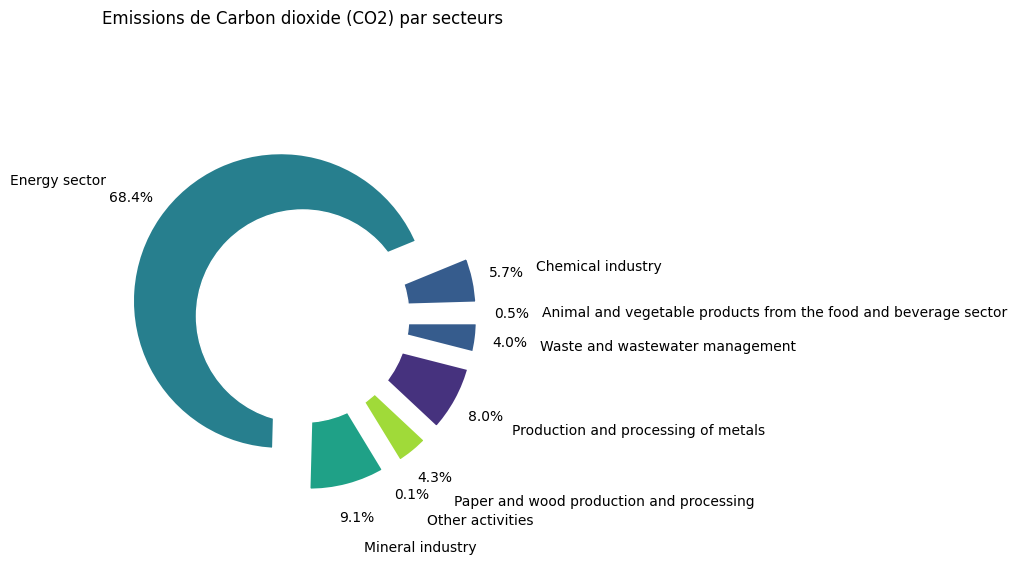

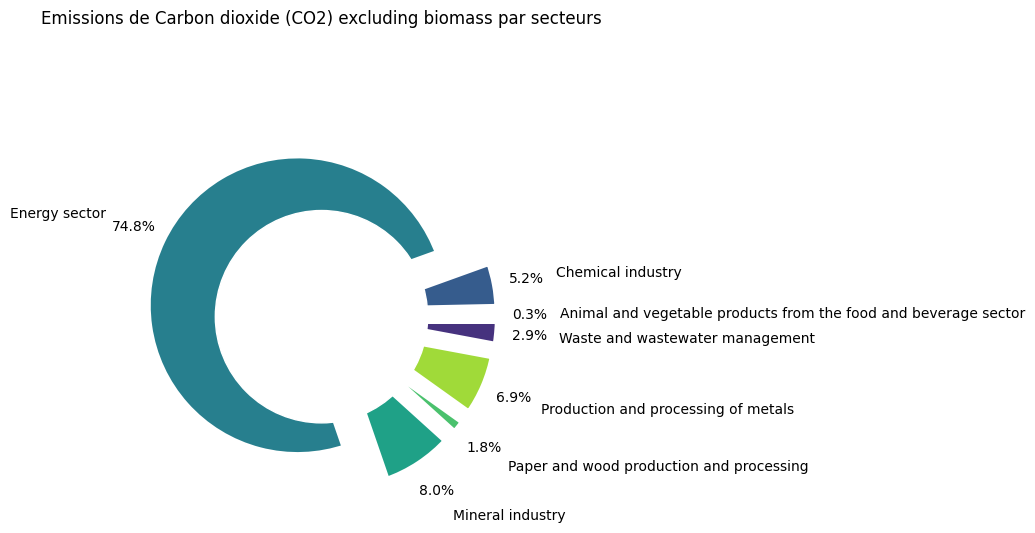

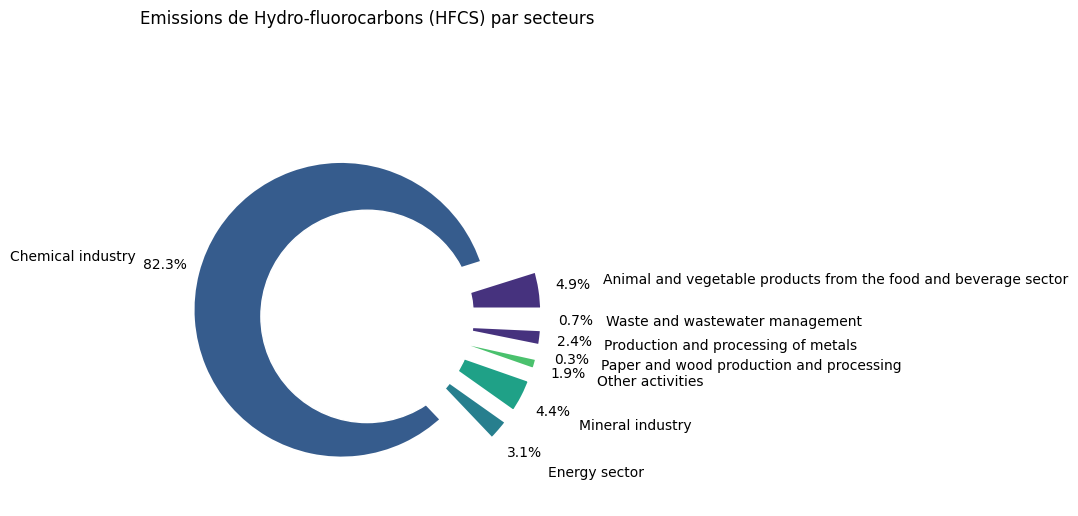

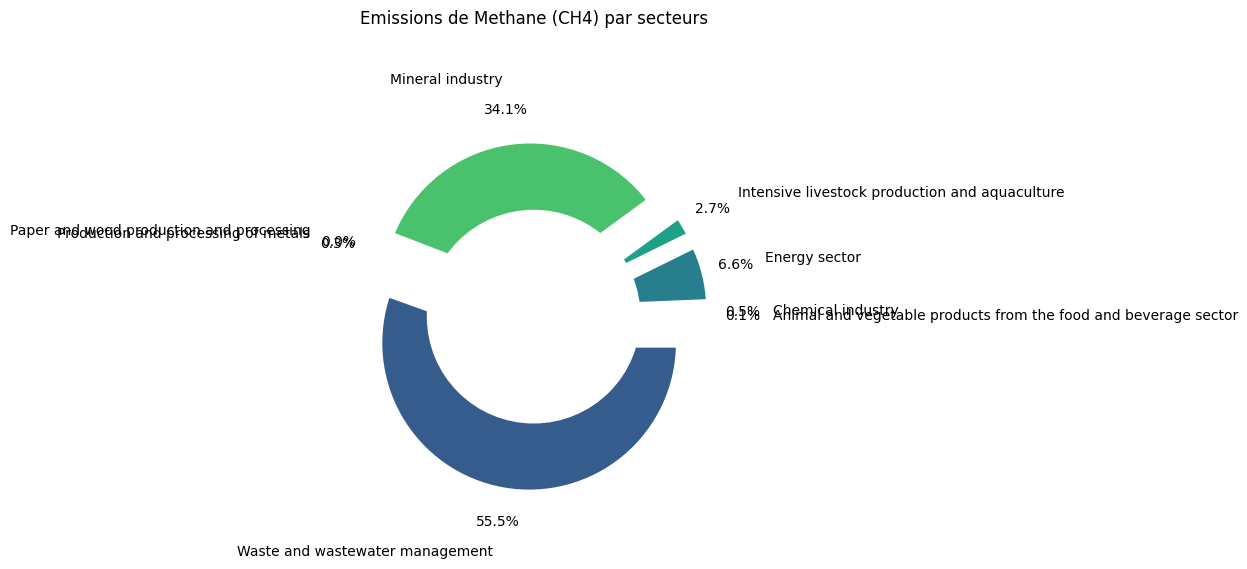

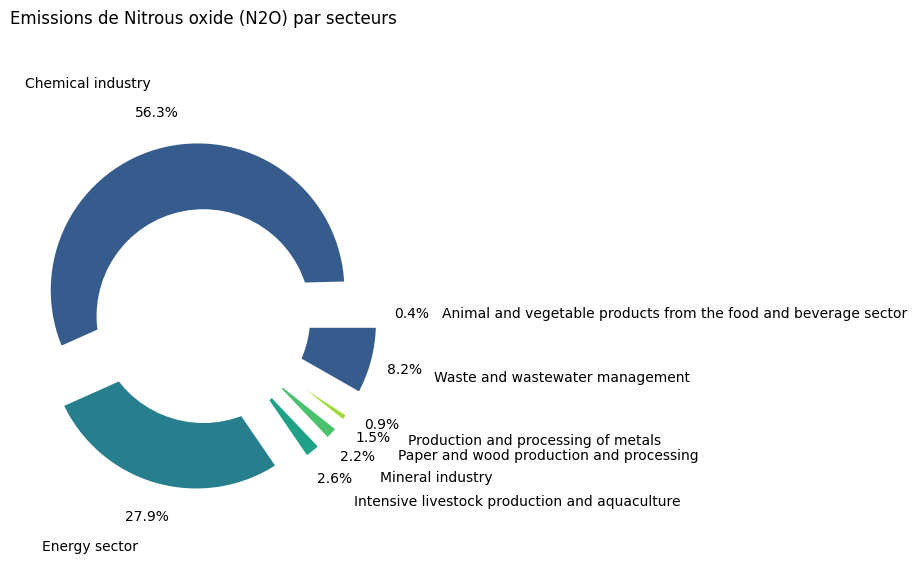

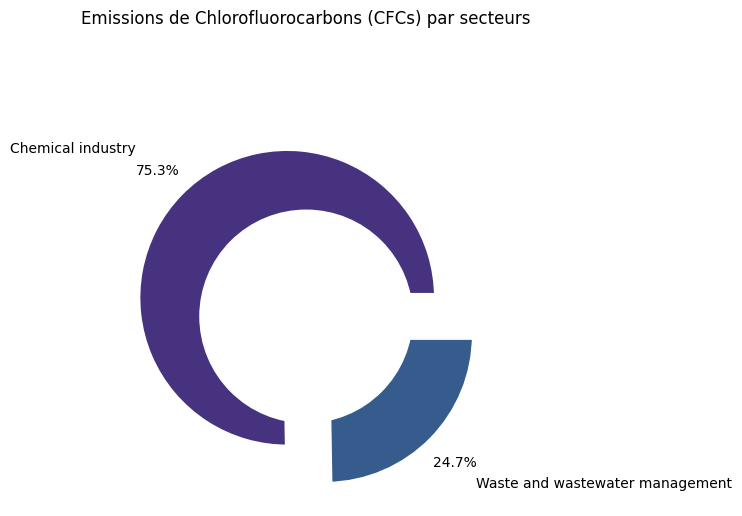

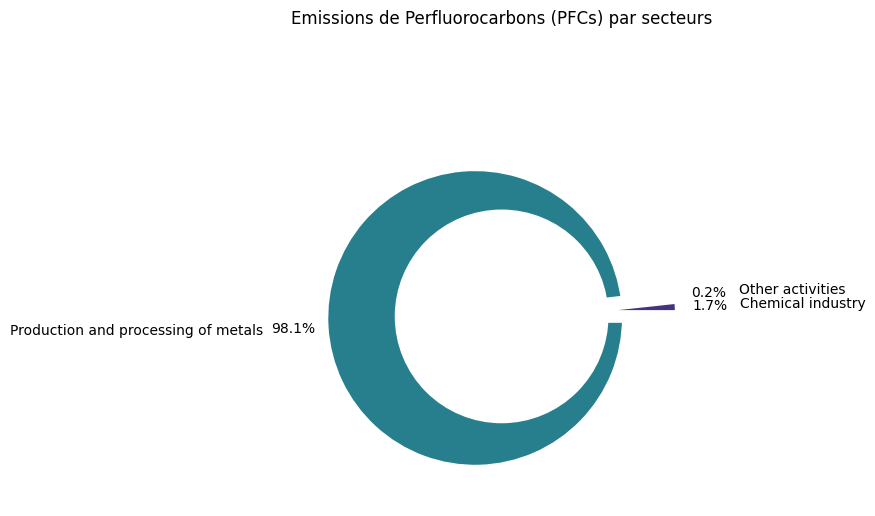

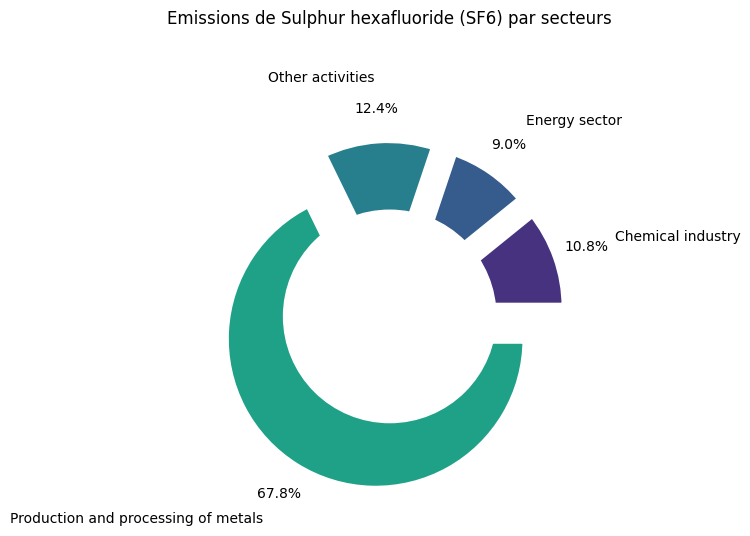

In [100]:
for index, pollutant in enumerate(gwp_group_by_pollutant_and_sector.index.get_level_values("pollutant").unique()):
    filter_pollutant = gwp_group_by_pollutant_and_sector[
        (gwp_group_by_pollutant_and_sector.index.get_level_values("pollutant") == pollutant)
    ]

    names = filter_pollutant.index.get_level_values("eprtrSectorName").unique()
    size = filter_pollutant["sum"]

    center_circle = plt.Circle( (0,0), 0.7, color='white')

    plt.pie(
        size,
        labels=names,
        wedgeprops={ 'linewidth' : 7, 'edgecolor' : 'white' },
        autopct='%1.1f%%',
        pctdistance=1.2,
        labeldistance=1.4,
        explode=[0.175] * len(names)
    )

    plt.title(f"Emissions de {pollutant} par secteurs",  y=1.25)

    p = plt.gcf()
    p.gca().add_artist(center_circle)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [101]:
df

countryName                           eprtrSectorName   
0          Austria                         Chemical industry  \
220        Austria                         Chemical industry   
436        Austria                         Chemical industry   
641        Austria                         Chemical industry   
852        Austria                         Chemical industry   
...            ...                                       ...   
212662    Portugal  Paper and wood production and processing   
212897    Portugal  Paper and wood production and processing   
212910    Portugal  Paper and wood production and processing   
212925    Portugal  Paper and wood production and processing   
213147    Portugal  Paper and wood production and processing   

                             EPRTRAnnexIMainActivityLabel   
0       Chemical installations for the production on a...  \
220     Chemical installations for the production on a...   
436     Chemical installations for the production on a...   
641     Chemical installations for the production on a...   
852     Chemical installations for the production on a...   
...                                                   ...   
212662  Industrial plants for the production of pulp f...   
212897  Industrial plants for the production of pulp f...   
212910  Industrial plants for the production of pulp f...   
212925  Industrial plants for the production of paper ...   
213147  Industrial plants for the production of pulp f...   

                     FacilityInspireID   
0       AT.CAED/9008390392737.FACILITY  \
220     AT.CAED/9008390392737.FACILITY   
436     AT.CAED/9008390392737.FACILITY   
641     AT.CAED/9008390392737.FACILITY   
852     AT.CAED/9008390392737.FACILITY   
...                                ...   
212662       PT.CAED/PT.APA05774482.CI   
212897       PT.CAED/PT.APA05765162.CI   
212910       PT.CAED/PT.APA05765202.CI   
212925       PT.CAED/PT.APA05765222.CI   
213147       PT.CAED/PT.APA05774482.CI   

                                        facilityName             City   
0                                Nufarm GmbH & CO KG             Linz  \
220                              Nufarm GmbH & CO KG             Linz   
436                              Nufarm GmbH & CO KG             Linz   
641                              Nufarm GmbH & CO KG             Linz   
852                              Nufarm GmbH & CO KG             Linz   
...                                              ...              ...   
212662  Celulose Beira Industrial (Celbi), S.A. (CI)  FIGUEIRA DA FOZ   
212897                        NAVIGATOR Setúbal (CI)          SETÚBAL   
212910               Navigator Pulp Cacia, S.A. (CI)           Aveiro   
212925                       Navigator Figueira (CI)            LAVOS   
213147  Celulose Beira Industrial (Celbi), S.A. (CI)  Figueira da Foz   

                           pollutant  emissions  reportingYear  count   
0       1,2-dichloroethane (DCE-1,2)     3300.0           2007    328  \
220     1,2-dichloroethane (DCE-1,2)     3310.0           2008    328   
436     1,2-dichloroethane (DCE-1,2)     2550.0           2009    328   
641     1,2-dichloroethane (DCE-1,2)     3220.0           2010    328   
852     1,2-dichloroethane (DCE-1,2)     2820.0           2011    328   
...                              ...        ...            ...    ...   
212662              Trichloromethane     7000.0           2020     69   
212897              Trichloromethane     4960.0           2021     69   
212910              Trichloromethane     3210.0           2021     69   
212925              Trichloromethane     5450.0           2021     69   
213147              Trichloromethane     7190.0           2021     69   

               sum  median          mean  category  gwpEmissions  
0       13083822.0  8675.0  39889.701220     0.250           0.0  
220     13083822.0  8675.0  39889.701220     0.250           0.0  
436     13083822.0  8675.0  39889.701220     

- Nettoyer facilityName
- Remplissage valeur manquante